# BIG DATA MINING REPORT (ASSESSMENT 2)

## Import all libraries

In [3]:
!pip install folium

In [1]:
import sqlite3
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import folium

from mpl_toolkits.mplot3d import Axes3D
from datetime import time
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import KMeans, DBSCAN
from folium.plugins import MarkerCluster
from sklearn.ensemble import IsolationForest
from imblearn.under_sampling import RandomUnderSampler
from numpy import exp, mean, std
from sklearn.neighbors import KernelDensity
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, train_test_split, GridSearchCV
from mlxtend.classifier import StackingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA

%matplotlib inline

#Suppress warnings
import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'folium'

## Connect to the database and read the dataset

Department for Transport (2022). Road Safety Data. [online] Data.gov.uk. Available at: https://www.data.gov.uk/dataset/cb7ae6f0-4be6-4935-9277-47e5ce24a11f/road-safety-data [Accessed 3 Aug. 2023].

In [2]:
con = sqlite3.connect("accident_data_v1.0.0_2023.db")
cur = con.cursor()

In [3]:
def dataframe_generator(x, accident_year=False):
    
    #Create an empty list
    x_ = []
    
    #Fetch all column names
    col_info = cur.execute(f"PRAGMA table_info('{x}')")
    x_col = col_info.fetchall()
    
    #Iterate thru to columns
    for i in x_col:
        x_.append(i[1])
    
    #Execute the cursor
    if accident_year == True:
        res = cur.execute(f"SELECT * FROM '{x}' WHERE accident_year = 2020")
        new = res.fetchall()
    else:
        res = cur.execute(f"SELECT * FROM '{x}'")
        new = res.fetchall()
    
    #Create a dataframe for the table
    x_df = pd.DataFrame(new, columns=x_)
    x_df
    
    
    #Return the dataframe
    return x_df

In [4]:
# Recall the function by creating dataframes

accident_2020 = dataframe_generator('accident', accident_year=True)
casualty_2020 = dataframe_generator('casualty', accident_year=True)
vehicle_2020 = dataframe_generator('vehicle', accident_year=True)
Lsoa_2020 = dataframe_generator('lsoa')

In [5]:
# Close the connection

con.close()

In [6]:
Lsoa_2020.sample(2)

objectid   lsoa01cd          lsoa01nm         lsoa01nmw   shape__area  \
20874     20875  E01020875  Wear Valley 004B  Wear Valley 004B  1.156986e+07   
20229     20230  E01020230  Teignbridge 005B  Teignbridge 005B  8.261266e+05   

       shape__length                              globalid  
20874   26954.877891  042a8258-b290-42a8-880f-3fde93f44733  
20229    6108.304303  47f2c0af-ea98-463f-9f0a-dcfa8d02f69c

In [7]:
vehicle_2020.sample(2)

vehicle_index accident_index  accident_year accident_reference  \
57060          738776  2020101003105           2020          101003105   
139741         821457  2020470978348           2020          470978348   

        vehicle_reference  vehicle_type  towing_and_articulation  \
57060                   1             9                        0   
139741                  2             9                        0   

        vehicle_manoeuvre  vehicle_direction_from  vehicle_direction_to  ...  \
57060                  18                       7                     3  ...   
139741                  3                       6                     1  ...   

        journey_purpose_of_driver  sex_of_driver  age_of_driver  \
57060                           5              2             49   
139741                          1              1             32   

        age_band_of_driver  engine_capacity_cc  propulsion_code  \
57060                    8                1229                1   
139741                   6                2993                2   

        age_of_vehicle  generic_make_model  driver_imd_decile  \
57060                8      VAUXHALL CORSA                 10   
139741               2              BMW X5                  6   

        driver_home_area_type  
57060                       1  
139741                      1  

[2 rows x 28 columns]

In [8]:
casualty_2020.sample(2)

casualty_index accident_index  accident_year accident_reference  \
55806          540554  2020220934573           2020          220934573   
96008          580756  2020470984676           2020          470984676   

       vehicle_reference  casualty_reference  casualty_class  sex_of_casualty  \
55806                  2                   1               1                2   
96008                  3                   1               1                1   

       age_of_casualty  age_band_of_casualty  casualty_severity  \
55806               21                     5                  3   
96008               28                     6                  3   

       pedestrian_location  pedestrian_movement  car_passenger  \
55806                    0                    0              0   
96008                    0                    0              0   

       bus_or_coach_passenger  pedestrian_road_maintenance_worker  \
55806                       0                                   0   
96008                       0                                   0   

       casualty_type  casualty_home_area_type  casualty_imd_decile  
55806              4                        1                    1  
96008              1                        1                    8

In [9]:
accident_2020.sample(2)

accident_index  accident_year accident_reference  location_easting_osgr  \
37281  2020140990373           2020          140990373               426754.0   
62881  2020430073976           2020          430073976               488675.0   

       location_northing_osgr  longitude   latitude  police_force  \
37281                398274.0  -1.598333  53.480530            14   
62881                178677.0  -0.723883  51.500088            43   

       accident_severity  number_of_vehicles  ...  \
37281                  3                   2  ...   
62881                  3                   2  ...   

       pedestrian_crossing_physical_facilities light_conditions  \
37281                                        0                1   
62881                                        0                1   

       weather_conditions road_surface_conditions  special_conditions_at_site  \
37281                   1                       1                           0   
62881                   1                       1                           0   

      carriageway_hazards urban_or_rural_area  \
37281                   0                   1   
62881                   0                   2   

       did_police_officer_attend_scene_of_accident  trunk_road_flag  \
37281                                            1                2   
62881                                            3                1   

       lsoa_of_accident_location  
37281                  E01008144  
62881                  E01016539  

[2 rows x 36 columns]

In [10]:
### For futuristic usage, a copy of the original dataset are made

accident_df = accident_2020.copy()
vehicle_df = vehicle_2020.copy()
casualty_df = casualty_2020.copy()

## Inspect and Investigate the dataset

**STATS 20 Department for Transport Instructions for the Completion of Road Accident Reports from non-CRASH Sources. (2011). Available at: https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/995423/stats20-2011.pdf**

(STATS 20 Department for Transport Instructions for the Completion of Road Accident Reports from non-CRASH Sources, 2011)

### Accident table

In [11]:
# General info of the table

accident_2020.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91199 entries, 0 to 91198
Data columns (total 36 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   accident_index                               91199 non-null  object 
 1   accident_year                                91199 non-null  int64  
 2   accident_reference                           91199 non-null  object 
 3   location_easting_osgr                        91185 non-null  float64
 4   location_northing_osgr                       91185 non-null  float64
 5   longitude                                    91185 non-null  float64
 6   latitude                                     91185 non-null  float64
 7   police_force                                 91199 non-null  int64  
 8   accident_severity                            91199 non-null  int64  
 9   number_of_vehicles                           91199 non-null  int64  
 10

In [12]:
# Check for missing values

accident_2020.isna().sum()

accident_index                                  0
accident_year                                   0
accident_reference                              0
location_easting_osgr                          14
location_northing_osgr                         14
longitude                                      14
latitude                                       14
police_force                                    0
accident_severity                               0
number_of_vehicles                              0
number_of_casualties                            0
date                                            0
day_of_week                                     0
time                                            0
local_authority_district                        0
local_authority_ons_district                    0
local_authority_highway                         0
first_road_class                                0
first_road_number                               0
road_type                                       0


In [13]:
# Check for duplicates

accident_2020.duplicated().sum()

0

In [14]:
# Columns present in accident table

accident_2020.columns

Index(['accident_index', 'accident_year', 'accident_reference',
       'location_easting_osgr', 'location_northing_osgr', 'longitude',
       'latitude', 'police_force', 'accident_severity', 'number_of_vehicles',
       'number_of_casualties', 'date', 'day_of_week', 'time',
       'local_authority_district', 'local_authority_ons_district',
       'local_authority_highway', 'first_road_class', 'first_road_number',
       'road_type', 'speed_limit', 'junction_detail', 'junction_control',
       'second_road_class', 'second_road_number',
       'pedestrian_crossing_human_control',
       'pedestrian_crossing_physical_facilities', 'light_conditions',
       'weather_conditions', 'road_surface_conditions',
       'special_conditions_at_site', 'carriageway_hazards',
       'urban_or_rural_area', 'did_police_officer_attend_scene_of_accident',
       'trunk_road_flag', 'lsoa_of_accident_location'],
      dtype='object')

In [15]:
# Identify columns with negative values
def negative_identifier(table):
    # Create an empty list to append the columns
    neg_list = []
    # values to identify
    find_values = [-1, '-1']
    for p in table.columns:
        if table[p].isin(find_values).any():
            neg_list.append(p)
    return neg_list

# Call back the function
negative_identifier(accident_2020)

['local_authority_district',
 'speed_limit',
 'junction_detail',
 'junction_control',
 'second_road_class',
 'second_road_number',
 'pedestrian_crossing_human_control',
 'pedestrian_crossing_physical_facilities',
 'light_conditions',
 'weather_conditions',
 'road_surface_conditions',
 'special_conditions_at_site',
 'carriageway_hazards',
 'did_police_officer_attend_scene_of_accident',
 'trunk_road_flag',
 'lsoa_of_accident_location']

In [16]:
# From stats20, no 99 present

print(accident_2020[accident_2020.police_force == 99].police_force.count())

## Checking for anomalies in the accident table

print(len(accident_2020[accident_2020.local_authority_district == -1]))

print(len(accident_2020[accident_2020.speed_limit < 20]))

print(accident_2020.speed_limit.unique())

print(len(accident_2020[accident_2020.junction_control == -1])) # -1 and 9 should not be present

print(accident_2020.junction_control.unique())

print(len(accident_2020[accident_2020.junction_control == 9])) #9 is not meant to be in this column

print(accident_2020.junction_control.unique())

print(len(accident_2020[accident_2020.junction_detail == -1])) ## 99 and -1 aint meant to be present

accident_2020.junction_detail.unique() #Replace 99 and -1 with 10

3836
991
12
[20 30 40 50 60 70 -1]
38298
[-1  2  1  4  9  3]
1536
[-1  2  1  4  9  3]
2


array([ 0,  9,  3,  6,  1, 99,  7,  8,  2,  5, -1], dtype=int64)

In [17]:
p = accident_2020[['junction_detail', 'junction_control', 'second_road_class', 'second_road_number']]
p.head()

junction_detail  junction_control  second_road_class  second_road_number
0                0                -1                  0                  -1
1                9                 2                  6                   0
2                3                 1                  6                   0
3                0                -1                  0                  -1
4                3                 4                  5                   0

In [18]:
print(p[(p.junction_detail == 0)].junction_control.unique())

print(len(p[(p.junction_detail == 0)].junction_control))

[-1  4]
37978


In [19]:
p[(p.junction_detail == 0) & (p.junction_control == 4)]

junction_detail  junction_control  second_road_class  \
8543                 0                 4                  0   
64304                0                 4                  0   

       second_road_number  
8543                   -1  
64304                  -1

In [20]:
print(len(accident_2020[accident_2020.second_road_class == -1])) # 0 and -1 should not be present

print(accident_2020.second_road_class.unique())

print(len(accident_2020[accident_2020.second_road_class == 0]))

print(len(accident_2020[accident_2020.first_road_class == 6]))

print(accident_2020[accident_2020.first_road_class == 6].second_road_class.unique())

print(len(accident_2020[accident_2020.second_road_number == -1]))

print(accident_2020.second_road_number.unique())

print(len(accident_2020[accident_2020.pedestrian_crossing_human_control == -1]))

print(accident_2020.pedestrian_crossing_human_control.unique()) # 9 and -1 is not supposed to be present

110
[ 0  6  5  3  4  1 -1  2]
37928
31709
[ 0  6  4  3  5  1 -1  2]
38045
[  -1    0  406 ...  999   87 7019]
143
[ 9  0  2  1 -1]


In [21]:
print(accident_2020[(accident_2020.pedestrian_crossing_human_control == 1) | (accident_2020.pedestrian_crossing_human_control == 2) & (accident_2020.junction_detail == 0)].first_road_class.unique())

print(len(accident_2020[accident_2020.pedestrian_crossing_physical_facilities == -1]))

print(accident_2020.pedestrian_crossing_physical_facilities.unique()) # 9 and -1 should not be present

print(len(accident_2020[accident_2020.light_conditions == -1]))

print(accident_2020.light_conditions.unique())

print(len(accident_2020[accident_2020.weather_conditions == -1]))

print(accident_2020.weather_conditions.unique()) # -1 should be changed to 9

[3 6 4 5]
135
[ 9  4  0  5  1  8  7 -1]
1
[ 1  4  5  7  6 -1]
1
[ 9  1  8  7  2  4  5  3  6 -1]


In [22]:
print(len(accident_2020[accident_2020.road_surface_conditions == -1]))

print(accident_2020.road_surface_conditions.unique()) # 9 and -1 should not be present

print(len(accident_2020[accident_2020.road_surface_conditions == 9]))

print(len(accident_2020[accident_2020.special_conditions_at_site == -1]))

print(accident_2020.special_conditions_at_site.unique()) # 9 and -1 should not be here

print(len(accident_2020[accident_2020.carriageway_hazards == -1]))

print(accident_2020.carriageway_hazards.unique()) # 9 and -1 should not be here

316
[ 9  1  2  5  4  3 -1]
847
218
[ 0  9  2  4  5  1  3  6  7 -1]
208
[ 0  2  9  6  3  1  7 -1]


In [23]:
print(len(accident_2020[accident_2020.did_police_officer_attend_scene_of_accident == -1]))

print(accident_2020.did_police_officer_attend_scene_of_accident.unique()) # -1 should not be here

print(len(accident_2020[accident_2020.trunk_road_flag == -1]))

print(accident_2020.trunk_road_flag.unique())

print(accident_2020.road_type.unique())

print(len(accident_2020[(accident_2020.speed_limit == 70) & (accident_2020.road_type == 9)]))

1
[ 3  1  2 -1]
6710
[ 2  1 -1]
[6 2 3 7 1 9]
18


### Vehicle table

In [24]:
# Inspecting vehicle table

vehicle_2020.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167375 entries, 0 to 167374
Data columns (total 28 columns):
 #   Column                            Non-Null Count   Dtype 
---  ------                            --------------   ----- 
 0   vehicle_index                     167375 non-null  int64 
 1   accident_index                    167375 non-null  object
 2   accident_year                     167375 non-null  int64 
 3   accident_reference                167375 non-null  object
 4   vehicle_reference                 167375 non-null  int64 
 5   vehicle_type                      167375 non-null  int64 
 6   towing_and_articulation           167375 non-null  int64 
 7   vehicle_manoeuvre                 167375 non-null  int64 
 8   vehicle_direction_from            167375 non-null  int64 
 9   vehicle_direction_to              167375 non-null  int64 
 10  vehicle_location_restricted_lane  167375 non-null  int64 
 11  junction_location                 167375 non-null  int64 
 12  sk

In [25]:
# Check for duplicates

vehicle_2020.duplicated().sum()

0

In [26]:
# Check for missing values

vehicle_2020.isna().sum()

vehicle_index                       0
accident_index                      0
accident_year                       0
accident_reference                  0
vehicle_reference                   0
vehicle_type                        0
towing_and_articulation             0
vehicle_manoeuvre                   0
vehicle_direction_from              0
vehicle_direction_to                0
vehicle_location_restricted_lane    0
junction_location                   0
skidding_and_overturning            0
hit_object_in_carriageway           0
vehicle_leaving_carriageway         0
hit_object_off_carriageway          0
first_point_of_impact               0
vehicle_left_hand_drive             0
journey_purpose_of_driver           0
sex_of_driver                       0
age_of_driver                       0
age_band_of_driver                  0
engine_capacity_cc                  0
propulsion_code                     0
age_of_vehicle                      0
generic_make_model                  0
driver_imd_d

In [27]:
# Call the function for negative identifier

negative_identifier(vehicle_2020)

['towing_and_articulation',
 'vehicle_manoeuvre',
 'vehicle_direction_from',
 'vehicle_direction_to',
 'vehicle_location_restricted_lane',
 'junction_location',
 'skidding_and_overturning',
 'hit_object_in_carriageway',
 'vehicle_leaving_carriageway',
 'hit_object_off_carriageway',
 'first_point_of_impact',
 'vehicle_left_hand_drive',
 'journey_purpose_of_driver',
 'sex_of_driver',
 'age_of_driver',
 'age_band_of_driver',
 'engine_capacity_cc',
 'propulsion_code',
 'age_of_vehicle',
 'generic_make_model',
 'driver_imd_decile',
 'driver_home_area_type']

In [28]:
print(vehicle_2020.vehicle_type.unique())

print(vehicle_2020.towing_and_articulation.unique()) # 9 and -1 should not be here

print(vehicle_2020.vehicle_manoeuvre.unique()) # 99 should not here

print(vehicle_2020.vehicle_direction_from.unique()) # -1 and 9 should not here

print(vehicle_2020.vehicle_direction_to.unique()) # -1 and 9 should not here

print(vehicle_2020.vehicle_location_restricted_lane.unique()) # 99 and -1 

print(vehicle_2020.junction_location.unique()) # -1 and 9

print(vehicle_2020.skidding_and_overturning.unique()) # -1 and 9

print(vehicle_2020.hit_object_in_carriageway.unique()) # 99 and -1

print(vehicle_2020.vehicle_leaving_carriageway.unique()) # -1

print(vehicle_2020.hit_object_off_carriageway.unique()) # 99 and -1

print(vehicle_2020.sex_of_driver.unique()) # -1

print(vehicle_2020.age_of_driver.unique()) # -1 nb: do not enter 000, 099 or 999, if not known

# blank if hit and run

[ 9  8  3  2 11  1 90 19  4  5 21 97 20 98 10 17 23 22 18 16]
[ 9  0  3  1  5  4 -1  2]
[ 5  4 18  3  2 99 11  1 17  9 14 13  7 15  6 16 10  8 12 -1]
[ 1  2 -1  3  5  0  7  9  8  6  4]
[ 5  6 -1  7  1  0  3  9  4  2  8]
[ 0  9 99  2  6  5  4  1  8  7 -1  3]
[ 0  2  1  6  9  7  8  5  3  4 -1]
[ 0  2  1  9  5 -1  3  4]
[ 0 10  4 11 99  7 12  1  8 -1  9  2  6  5]
[ 0  7  1  9  3  4  2  8  6  5 -1]
[ 0 11  2 99  4  1  5 10  3  7  9 -1  6  8]
[ 2  1  3 -1]
[ 32  45  -1  44  20  25  41  19  26  62  37  40  33  51  30  18  29  24
  38  77  48  50  79  42  52  22  31  28  57  81  59  67  34  23  54  53
  27  39  56  43  88  35  46  16  49  21  80  66  55  47  60  36  58  70
  71  17  85  69  61  87  73  64  65  63  83  78  72  68  14  82  74  75
  11  76  15  86  90   9  10  91  84  13   8  89  93  94  92   6  12   5
   4   7  97  95   3  98 100  99  96]


In [29]:
#If 2.5 (Vehicle Type) is coded 02 - 05, 08 - 11, 17 - 21, 23, 97 or 98 then the local processing authority should query the driver age if this is under 16.

print(vehicle_2020[(vehicle_2020.vehicle_type >= 2) & (vehicle_2020.vehicle_type <= 5) & (vehicle_2020.age_of_driver < 16)].age_of_driver.unique())

print(vehicle_2020[(vehicle_2020.vehicle_type >= 8) & (vehicle_2020.vehicle_type <= 11)& (vehicle_2020.age_of_driver < 16)].age_of_driver.unique())

#8, 5, 13, 14, 15 and -1

print(vehicle_2020[(vehicle_2020.vehicle_type >= 17) & (vehicle_2020.vehicle_type <= 21) & (vehicle_2020.age_of_driver < 16)].age_of_driver.unique()) # -15

print(vehicle_2020[(vehicle_2020.vehicle_type == 23) | (vehicle_2020.vehicle_type == 97) | (vehicle_2020.vehicle_type == 98) & (vehicle_2020.age_of_driver < 16)].age_of_driver.unique()) # 12, 13, 14, 15

[-1 14 15 13 12 11]
[-1 15 14  5 13 11  8]
[-1 15]
[-1 21 24 25 18 44 37 57 20 22 45 30 28 50 36 17 33 38 39 47 23 35 56 32
 55 61 16 29 62 26 40 64 52 34 27 15 49 31 43 54 59 60 53 83 67 19 51 72
 79 12 13 14 68 41 42 46 63 65 11 69 66 48]


In [30]:
print(len(vehicle_2020[(vehicle_2020.vehicle_type == 23) | (vehicle_2020.vehicle_type == 97) | (vehicle_2020.vehicle_type == 98) & (vehicle_2020.age_of_driver < 16)].age_of_driver.unique()))

print(len(vehicle_2020[(vehicle_2020.vehicle_type >= 17) & (vehicle_2020.vehicle_type <= 21) & (vehicle_2020.age_of_driver < 16)].age_of_driver.unique()))

print(len(vehicle_2020[(vehicle_2020.vehicle_type >= 8) & (vehicle_2020.vehicle_type <= 11) & (vehicle_2020.age_of_driver < 16)].age_of_driver.unique()))

print(len(vehicle_2020[(vehicle_2020.vehicle_type >= 2) & (vehicle_2020.vehicle_type <= 5) & (vehicle_2020.age_of_driver < 16)].age_of_driver.unique()))

62
2
7
6


In [31]:
print(vehicle_2020.journey_purpose_of_driver.unique()) # -1

print(vehicle_2020.vehicle_left_hand_drive.unique()) # -1 and 9

print(len(vehicle_2020[(vehicle_2020.vehicle_left_hand_drive == -1) | (vehicle_2020.vehicle_type == 9)]))


[ 6  2  1 -1  3  4  5]
[ 9  1 -1  2]
115022


### Casualty table

In [32]:
# Check for missing values

casualty_2020.isna().sum()

casualty_index                        0
accident_index                        0
accident_year                         0
accident_reference                    0
vehicle_reference                     0
casualty_reference                    0
casualty_class                        0
sex_of_casualty                       0
age_of_casualty                       0
age_band_of_casualty                  0
casualty_severity                     0
pedestrian_location                   0
pedestrian_movement                   0
car_passenger                         0
bus_or_coach_passenger                0
pedestrian_road_maintenance_worker    0
casualty_type                         0
casualty_home_area_type               0
casualty_imd_decile                   0
dtype: int64

In [33]:
# Check for duplicates

casualty_2020.duplicated().sum()

0

In [34]:
# Call back the function

negative_identifier(casualty_2020)

['sex_of_casualty',
 'age_of_casualty',
 'age_band_of_casualty',
 'pedestrian_location',
 'pedestrian_movement',
 'car_passenger',
 'bus_or_coach_passenger',
 'pedestrian_road_maintenance_worker',
 'casualty_home_area_type',
 'casualty_imd_decile']

In [35]:
print(casualty_2020.casualty_class.unique())

print(len(casualty_2020[(casualty_2020.sex_of_casualty == -1) | (casualty_2020.sex_of_casualty == 9)]))

print(casualty_2020.sex_of_casualty.unique()) # -1 and 9

casualty_2020.casualty_reference.unique()

[3 1 2]
761
[ 1  2 -1  9]


array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  40,  12,
        13,  14,  15,  16,  17,  33,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  34,  35,  36,  37,  38,
        39,  41, 902, 992], dtype=int64)

In [36]:
print(casualty_2020.casualty_severity.unique())

print(casualty_2020.pedestrian_location.unique()) # -1 and 0 replace with 10

print(casualty_2020.pedestrian_movement.unique()) # 0 and -1 replace with 9 that's unknown or other

print(casualty_2020.car_passenger.unique()) # -1 and 9

print(casualty_2020.bus_or_coach_passenger.unique()) # 9 and -1

print(casualty_2020.pedestrian_road_maintenance_worker.unique()) # -1

# If no estimate is made it will not be possible to classify the casualty as even child or adult. Thus every effort should be made to estimate an age.

print(casualty_2020[casualty_2020.age_of_casualty == -1].age_of_casualty.count())

casualty_2020.age_of_casualty.unique()

[3 2 1]
[ 9  1  5  4  6  0 10  8  7  3  2 -1]
[ 5  1  9  0  3  2  8  4  7  6 -1]
[ 0  1  2  9 -1]
[ 0  4  3  1  2  9 -1]
[ 0  1  2 -1]
2481


array([31,  2,  4, 23, 47, 32, 33, 25, 41, 50, 62, 37, -1, 20, 42, 30, 18,
       26, 29, 38, 39, 80, 19, 21, 48,  7, 79, 45, 27, 44, 51, 83, 52, 43,
       22, 59, 60, 77, 12, 54, 10, 40, 56, 24, 88, 11,  9, 35,  5,  3, 16,
       57, 67,  6, 49, 46, 53, 28, 69, 15, 76, 36, 55, 61, 85, 34,  8, 87,
       58, 73, 64, 65,  0, 78, 71, 14, 13, 17,  1, 68, 91, 66, 92, 74, 75,
       63, 70, 84, 86, 94, 72, 90, 81, 82, 89, 93, 96, 95, 98, 99, 97],
      dtype=int64)

In [37]:
s = accident_2020.select_dtypes('int')
s.columns

Index(['accident_year', 'police_force', 'accident_severity',
       'number_of_vehicles', 'number_of_casualties', 'day_of_week',
       'local_authority_district', 'first_road_class', 'first_road_number',
       'road_type', 'speed_limit', 'junction_detail', 'junction_control',
       'second_road_class', 'second_road_number',
       'pedestrian_crossing_human_control',
       'pedestrian_crossing_physical_facilities', 'light_conditions',
       'weather_conditions', 'road_surface_conditions',
       'special_conditions_at_site', 'carriageway_hazards',
       'urban_or_rural_area', 'did_police_officer_attend_scene_of_accident',
       'trunk_road_flag'],
      dtype='object')

In [38]:
p = vehicle_2020.select_dtypes('int')
p.columns

Index(['vehicle_index', 'accident_year', 'vehicle_reference', 'vehicle_type',
       'towing_and_articulation', 'vehicle_manoeuvre',
       'vehicle_direction_from', 'vehicle_direction_to',
       'vehicle_location_restricted_lane', 'junction_location',
       'skidding_and_overturning', 'hit_object_in_carriageway',
       'vehicle_leaving_carriageway', 'hit_object_off_carriageway',
       'first_point_of_impact', 'vehicle_left_hand_drive',
       'journey_purpose_of_driver', 'sex_of_driver', 'age_of_driver',
       'age_band_of_driver', 'engine_capacity_cc', 'propulsion_code',
       'age_of_vehicle', 'driver_imd_decile', 'driver_home_area_type'],
      dtype='object')

In [39]:
q = casualty_2020.select_dtypes('int')
q.columns

Index(['casualty_index', 'accident_year', 'vehicle_reference',
       'casualty_reference', 'casualty_class', 'sex_of_casualty',
       'age_of_casualty', 'age_band_of_casualty', 'casualty_severity',
       'pedestrian_location', 'pedestrian_movement', 'car_passenger',
       'bus_or_coach_passenger', 'pedestrian_road_maintenance_worker',
       'casualty_type', 'casualty_home_area_type', 'casualty_imd_decile'],
      dtype='object')

## Data Cleaning and Preprocessing

**The following can be observed from the dataset:**

> * Missing values in accident table
> * These columns in the accident table have -1 present: **trunk_road_flag, did_police_officer_attend_scene_of_accident, carriageway_hazards, special_conditions_at_site, weather_conditions, light_conditions, pedestrian_crossing_physical_facilities, road_surface_conditions, pedestrian_crossing_human_control, second_road_number, second_road_class, junction_control, junction_detail, local_authority_district, speed_limit**
> * Police Force column with value equals 99
> * These columns in the accident table have 0, 9 or 99 present: **pedestrian_crossing_physical_facilities, road_surface_conditions, junction_detail (99), junction_control, second_road_class (0), pedestrian_crossing_human_control, special_conditions_at_site**
> * These columns in the vehicle table have -1 present: **vehicle_left_hand_drive, journey_purpose_of_driver, vehicle_type, hit_object_in_carriageway, vehicle_leaving_carriageway, hit_object_off_carriageway, vehicle_manoeuvre, towing_and_articulation, vehicle_direction_from, vehicle_direction_to, vehicle_location_restricted_lane, junction_location, skidding_and_overturning, sex_of_driver, age_of_driver**
> * These columns in the vehicle table have 0, 9 or 99 present: **vehicle_left_hand_drive, hit_object_in_carriageway (99), vehicle_leaving_carriageway, hit_object_off_carriageway (99), vehicle_manoeuvre (99), towing_and_articulation, vehicle_location_restricted_lane (99), junction_location, skidding_and_overturning**
> * Inconsistent data entry in vehicle table e.g individuals below 16 driving certain types of vehicle
> * These columns in the casualty table have -1 present: **pedestrian_road_maintenance_worker, bus_or_coach_passenger, car_passenger, pedestrian_movement, pedestrian_location, age_of_casualty, sex_of_casualty** 
> * These columns in the casualty table have 0, 9 or 99 present: **bus_or_coach_passenger, car_passenger, pedestrian_movement (0), pedestrian_location (0), sex_of_casualty**

### Case 1: Missing values in Accident table

In [40]:
# Missing values in some columns
def treating_long_lat(x):
    long = accident_2020[accident_2020[x].isna()==True]

    # Iterate thru this dataframe
    for i, j in long.iterrows():
        district = accident_2020[accident_2020.local_authority_ons_district == j['local_authority_ons_district']][x]
        val = list(district.mode())[0]
        accident_2020.at[i, x] = val

        
# Replace the 4 columns with their mode values based on most occurring within a location

treating_long_lat('longitude')
treating_long_lat('latitude')
treating_long_lat('location_easting_osgr')
treating_long_lat('location_northing_osgr')

### Case 2: Police Force column with value equals 99

In [41]:
"""According to ANNEX 6 - POLICE FORCE CODE NUMBERS, 99 isnt present hence, further inspection needs to be done"""

force_code = {98 : ['S12000006'],
97 : ['S12000035', 'S12000008', 'S12000009', 'S12000011', 'S12000043', 'S12000018', 'S12000021', 'S12000044', 'S12000038', 'S12000028', 'S12000029', 'S12000039'],
96 : ['S12000005', 'S12000014', 'S12000030'],
95 : ['S12000010', 'S12000036', 'S12000019', 'S12000026', 'S12000040'],
94 : ['S12000015'],   
93 : ['S12000041', 'S12000042', 'S12000024'],
92 : ['S12000033', 'S12000034', 'S12000020'],
91 : ['S12000017', 'S12000013', 'S12000023', 'S12000027']}

# Iterate thru to replace with the correct values
for i, j in accident_2020.iterrows():
    for k, v in force_code.items():
        if j['police_force'] == 99 and j['local_authority_ons_district'] in v:
            accident_2020.at[i, 'police_force'] = k

### Case 3: Addressing -1 in Accident table columns

In [42]:
# Firstly, replace all -1 in the dataframes with null

accident_2020.replace([-1, '-1'], np.nan, inplace=True)
vehicle_2020.replace([-1, '-1'], np.nan, inplace=True)
casualty_2020.replace(-1, np.nan, inplace=True)

In [43]:
 #Numpy.org. (2022). numpy.clip — NumPy v1.25 Manual. [online] Available at: https://numpy.org/doc/stable/reference/generated/numpy.clip.html [Accessed 1 Aug. 2023]. 
    
# Create a function to replace null values with kde imputed values

def column_modification(table, col):
    """
    This function iterates through a column and replaces the null values with a kde imputed values
    """
    model = KernelDensity(bandwidth=2, kernel='gaussian')
    
    #Reshape
    val = table[col].dropna().values.reshape(-1,1)
    model.fit(val)
    
    #Select within the range
    min_ = table[col].min()
    max_ = table[col].max()
    new = model.sample(sum(table[col].isna()), random_state=42).flatten() 
    
    #Replace values using clip from numpy library   
    table[col][table[col].isna()] = np.clip(np.exp(new), min_, max_)

Amir Masoud Sefidian - Sefidian Academy. (2017). Kernel Density Estimation (KDE) in Python. [online] Available at: https://www.sefidian.com/2017/06/14/kernel-density-estimation-kde-in-python/ [Accessed 1 Aug. 2023].

##### Treating certain conditions based on stats 20

In [44]:
"""1 = Motorway, 2 = A(M), 3 = A, 4 = B, 5 = C, 6 = Unclassified"""

# We assume data missing or out_of_range values = 6 inplace of np.nan

for no, line in accident_2020.iterrows():
    if line['second_road_class'] == np.nan and line['junction_detail'] == 8:
#Where Junction Type is coded as ‘Using private drive or entrance’, 2nd Road Class should be coded ‘6 – Unclassified’.
        accident_2020.at[no, 'second_road_class'] = 6

"""1 = Daylight, 4 = Darkness: street lights present and lit, 5 = Darkness: street lights present but unlit,
6 = Darkness: no street lighting, 7 = Darkness: street lighting unknown"""

# We assume data missing or out_of_range values = 7 inplace of -1 since 7 already exist as unknown
#NB: The use of code 7 should be avoided if at all possible as stated in stats20 but in this situation, we cant impute any value

accident_2020['light_conditions'] = accident_2020['light_conditions'].replace(np.nan, 7)

"""1 = Fine without high winds, 2 = Raining without high winds, 3 = Snowing without high winds, 4 = Fine with high winds, 
5 = Raining with high winds, 6 = Snowing with high winds, 7 = Fog or mist - if hazard, 8 = Other, 9 = Unknown"""

# We assume data missing or out_of_range values = 9 inplace of -1 since 9 already exist as unknown

accident_2020['weather_conditions'] = accident_2020['weather_conditions'].replace(np.nan, 9)

# To be completed for 'junction accidents' only. If item 1.16 (Junction Detail) is coded 00, leave 1.17 blank.

#Assign 0 since this is meant to be blank

accident_2020['junction_control'] = accident_2020['junction_control'].replace(np.nan, 0)

In [45]:
# External source was used to obtain these values. The mode of the district or district_ons were used to fix these rows
            
j = (((accident_2020['local_authority_ons_district'] == 'S12000017') & (pd.isna(accident_2020['lsoa_of_accident_location']))))
accident_2020.loc[j, 'lsoa_of_accident_location'] = 'S01010620'
k = (((accident_2020['local_authority_ons_district'] == 'S12000013') & (pd.isna(accident_2020['lsoa_of_accident_location']))))
accident_2020.loc[k, 'lsoa_of_accident_location'] = 'S01009041'
l = (((accident_2020['local_authority_ons_district'] == 'S12000023') & (pd.isna(accident_2020['lsoa_of_accident_location']))))
accident_2020.loc[l, 'lsoa_of_accident_location'] = 'S01011821'
m = (((accident_2020['local_authority_ons_district'] == 'S12000027') & (pd.isna(accident_2020['lsoa_of_accident_location']))))
accident_2020.loc[m, 'lsoa_of_accident_location'] = 'S01012396'
n = (((accident_2020['local_authority_ons_district'] == 'S12000033') & (pd.isna(accident_2020['lsoa_of_accident_location']))))
accident_2020.loc[n, 'lsoa_of_accident_location'] = 'S01006608'
o = (((accident_2020['local_authority_ons_district'] == 'S12000034') & (pd.isna(accident_2020['lsoa_of_accident_location']))))
accident_2020.loc[o, 'lsoa_of_accident_location'] = 'S01007043'
p = (((accident_2020['local_authority_ons_district'] == 'S12000020') & (pd.isna(accident_2020['lsoa_of_accident_location']))))
accident_2020.loc[p, 'lsoa_of_accident_location'] = 'S01011121'
q = (((accident_2020['local_authority_ons_district'] == 'S12000041') & (pd.isna(accident_2020['lsoa_of_accident_location']))))
accident_2020.loc[q, 'lsoa_of_accident_location'] = 'S01007259'
r = (((accident_2020['local_authority_ons_district'] == 'S12000042') & (pd.isna(accident_2020['lsoa_of_accident_location']))))
accident_2020.loc[r, 'lsoa_of_accident_location'] = 'S01007694'
s = (((accident_2020['local_authority_ons_district'] == 'S12000024') & (pd.isna(accident_2020['lsoa_of_accident_location']))))
accident_2020.loc[s, 'lsoa_of_accident_location'] = 'S01011891'
t = (((accident_2020['local_authority_ons_district'] == 'S12000015') & (pd.isna(accident_2020['lsoa_of_accident_location']))))
accident_2020.loc[t, 'lsoa_of_accident_location'] = 'S01009309'
u = (((accident_2020['local_authority_ons_district'] == 'S12000010') & (pd.isna(accident_2020['lsoa_of_accident_location']))))
accident_2020.loc[u, 'lsoa_of_accident_location'] = 'S01008257'
v = (((accident_2020['local_authority_ons_district'] == 'S12000036') & (pd.isna(accident_2020['lsoa_of_accident_location']))))
accident_2020.loc[v, 'lsoa_of_accident_location'] = 'S01008806'
p = (((accident_2020['local_authority_ons_district'] == 'S12000019') & (pd.isna(accident_2020['lsoa_of_accident_location']))))
accident_2020.loc[p, 'lsoa_of_accident_location'] = 'S01010999'
     
p = (((accident_2020['local_authority_ons_district'] == 'S12000026') & (pd.isna(accident_2020['lsoa_of_accident_location']))))
accident_2020.loc[p, 'lsoa_of_accident_location'] = 'S01012275'
p = (((accident_2020['local_authority_ons_district'] == 'S12000040') & (pd.isna(accident_2020['lsoa_of_accident_location']))))
accident_2020.loc[p, 'lsoa_of_accident_location'] = 'S01013309'
p = (((accident_2020['local_authority_ons_district'] == 'S12000005') & (pd.isna(accident_2020['lsoa_of_accident_location']))))
accident_2020.loc[p, 'lsoa_of_accident_location'] = 'S01007466'
     

p = (((accident_2020['local_authority_ons_district'] == 'S12000014') & (pd.isna(accident_2020['lsoa_of_accident_location']))))
accident_2020.loc[p, 'lsoa_of_accident_location'] = 'S01009140'
p = (((accident_2020['local_authority_ons_district'] == 'S12000030') & (pd.isna(accident_2020['lsoa_of_accident_location']))))
accident_2020.loc[p, 'lsoa_of_accident_location'] = 'S01013066'
p = (((accident_2020['local_authority_ons_district'] == 'S12000035') & (pd.isna(accident_2020['lsoa_of_accident_location']))))
accident_2020.loc[p, 'lsoa_of_accident_location'] = 'S01007395'
     

p = (((accident_2020['local_authority_ons_district'] == 'S12000008') & (pd.isna(accident_2020['lsoa_of_accident_location']))))
accident_2020.loc[p, 'lsoa_of_accident_location'] = 'S01007975'
p = (((accident_2020['local_authority_ons_district'] == 'S12000009') & (pd.isna(accident_2020['lsoa_of_accident_location']))))
accident_2020.loc[p, 'lsoa_of_accident_location'] = 'S01008078'
p = (((accident_2020['local_authority_ons_district'] == 'S12000011') & (pd.isna(accident_2020['lsoa_of_accident_location']))))
accident_2020.loc[p, 'lsoa_of_accident_location'] = 'S01008409'
p = (((accident_2020['local_authority_ons_district'] == 'S12000043') & (pd.isna(accident_2020['lsoa_of_accident_location']))))
accident_2020.loc[p, 'lsoa_of_accident_location'] = 'S01010275'
p = (((accident_2020['local_authority_ons_district'] == 'S12000018') & (pd.isna(accident_2020['lsoa_of_accident_location']))))
accident_2020.loc[p, 'lsoa_of_accident_location'] = 'S01010894'
p = (((accident_2020['local_authority_ons_district'] == 'S12000021') & (pd.isna(accident_2020['lsoa_of_accident_location']))))
accident_2020.loc[p, 'lsoa_of_accident_location'] = 'S01011227'

p = (((accident_2020['local_authority_ons_district'] == 'S12000044') & (pd.isna(accident_2020['lsoa_of_accident_location']))))
accident_2020.loc[p, 'lsoa_of_accident_location'] = 'S01011745'
p = (((accident_2020['local_authority_ons_district'] == 'S12000038') & (pd.isna(accident_2020['lsoa_of_accident_location']))))
accident_2020.loc[p, 'lsoa_of_accident_location'] = 'S01012182'
     
p = (((accident_2020['local_authority_ons_district'] == 'S12000028') & (pd.isna(accident_2020['lsoa_of_accident_location']))))
accident_2020.loc[p, 'lsoa_of_accident_location'] = 'S01012481'
p = (((accident_2020['local_authority_ons_district'] == 'S12000029') & (pd.isna(accident_2020['lsoa_of_accident_location']))))
accident_2020.loc[p, 'lsoa_of_accident_location'] = 'S01012928'
p = (((accident_2020['local_authority_ons_district'] == 'S12000039') & (pd.isna(accident_2020['lsoa_of_accident_location']))))
accident_2020.loc[p, 'lsoa_of_accident_location'] = 'S01013129'
p = (((accident_2020['local_authority_ons_district'] == 'S12000006') & (pd.isna(accident_2020['lsoa_of_accident_location']))))
accident_2020.loc[p, 'lsoa_of_accident_location'] = 'S01007612'
p = (((accident_2020['local_authority_ons_district'] == 'E06000026') & (pd.isna(accident_2020['lsoa_of_accident_location']))))
accident_2020.loc[p, 'lsoa_of_accident_location'] = 'E01015092'


p = (((accident_2020['local_authority_ons_district'] == 'E08000013') & (pd.isna(accident_2020['lsoa_of_accident_location']))))
accident_2020.loc[p, 'lsoa_of_accident_location'] = 'E01006912'
p = (((accident_2020['local_authority_ons_district'] == 'E06000050') & (pd.isna(accident_2020['lsoa_of_accident_location']))))
accident_2020.loc[p, 'lsoa_of_accident_location'] = 'E01018360'
p = (((accident_2020['local_authority_ons_district'] == 'E07000164') & (pd.isna(accident_2020['lsoa_of_accident_location']))))
accident_2020.loc[p, 'lsoa_of_accident_location'] = 'E01027592'
p = (((accident_2020['local_authority_ons_district'] == 'E08000036') & (pd.isna(accident_2020['lsoa_of_accident_location']))))
accident_2020.loc[p, 'lsoa_of_accident_location'] = 'E01011935'
p = (((accident_2020['local_authority_ons_district'] == 'E06000024') & (pd.isna(accident_2020['lsoa_of_accident_location']))))
accident_2020.loc[p, 'lsoa_of_accident_location'] = 'E01014801'
p = (((accident_2020['local_authority_ons_district'] == 'W06000015') & (pd.isna(accident_2020['lsoa_of_accident_location']))))
accident_2020.loc[p, 'lsoa_of_accident_location'] = 'W01001759'
p = (((accident_2020['local_authority_ons_district'] == 'W06000010') & (pd.isna(accident_2020['lsoa_of_accident_location']))))
accident_2020.loc[p, 'lsoa_of_accident_location'] = 'W01000654'
p = (((accident_2020['local_authority_ons_district'] == 'W06000009') & (pd.isna(accident_2020['lsoa_of_accident_location']))))
accident_2020.loc[p, 'lsoa_of_accident_location'] = 'W01000573'
p = (((accident_2020['local_authority_ons_district'] == 'W06000023') & (pd.isna(accident_2020['lsoa_of_accident_location']))))
accident_2020.loc[p, 'lsoa_of_accident_location'] = 'W01000480'

Doogal.co.uk. (2021). Postcode downloads. [online] Available at: https://www.doogal.co.uk/PostcodeDownloads [Accessed 1 Aug. 2023].

### Case 4: Addressing 0, 9 and 99 in Accident table columns

In [46]:
# Replacing 0, 9 and 99 with the respective columns

accident_2020['pedestrian_crossing_human_control'].replace(9, np.nan, inplace=True)
accident_2020['road_surface_conditions'].replace(9, np.nan, inplace=True)
accident_2020['junction_detail'].replace(99, np.nan, inplace=True)
accident_2020['junction_control'].replace([9,0], np.nan, inplace=True)
accident_2020['second_road_class'].replace(0, np.nan, inplace=True)
accident_2020['pedestrian_crossing_physical_facilities'].replace(9, np.nan, inplace=True)
accident_2020['special_conditions_at_site'].replace(9, np.nan, inplace=True)

#### APPLYING THE KDE IMPUTATION IN FIXING THE MISSING VALUES BY CALLING THE FUNCTION

# Iterate through the columns of vehicle dataframe
for col in accident_2020.columns: 
    
    # Replace with the kde imputation
    if accident_2020[col].isna().any(): 
        column_modification(accident_2020, col)
        

new_list = ['accident_year', 'police_force', 'accident_severity',
       'number_of_vehicles', 'number_of_casualties', 'day_of_week',
       'local_authority_district', 'first_road_class', 'first_road_number',
       'road_type', 'speed_limit', 'junction_detail', 'junction_control',
       'second_road_class', 'second_road_number',
       'pedestrian_crossing_human_control',
       'pedestrian_crossing_physical_facilities', 'light_conditions',
       'weather_conditions', 'road_surface_conditions',
       'special_conditions_at_site', 'carriageway_hazards',
       'urban_or_rural_area', 'did_police_officer_attend_scene_of_accident',
       'trunk_road_flag']

# Convert values obtained from the KDE to int
for column in accident_2020.columns:
    if column in new_list:
        accident_2020[column] = accident_2020[column].astype('int')

### Case 5: Addressing 0, 9 and 99 in Vehicle table columns

In [47]:
# Replacing 0, 9 and 99 with the respective columns

vehicle_2020['vehicle_left_hand_drive'].replace(9, np.nan, inplace=True)
vehicle_2020['hit_object_in_carriageway'].replace(99, np.nan, inplace=True)
vehicle_2020['vehicle_leaving_carriageway'].replace(9, np.nan, inplace=True)
vehicle_2020['hit_object_off_carriageway'].replace(99, np.nan, inplace=True)
vehicle_2020['vehicle_manoeuvre'].replace(99, np.nan, inplace=True)
vehicle_2020['towing_and_articulation'].replace(9, np.nan, inplace=True)
vehicle_2020['vehicle_location_restricted_lane'].replace(99, np.nan, inplace=True)
vehicle_2020['junction_location'].replace(9, np.nan, inplace=True)
vehicle_2020['skidding_and_overturning'].replace(9, np.nan, inplace=True)
vehicle_2020['first_point_of_impact'].replace(9, np.nan, inplace=True)

### Case 6: Addressing -1 in Vehicle table columns

In [48]:
# Replace the generic_make_model with ffill

vehicle_2020['generic_make_model'].fillna(method='ffill', inplace=True)

###Call the function using a function 

# Iterate through the columns of vehicle dataframe
for col in vehicle_2020.columns: 
    
    # Replace with the kde imputation
    if vehicle_2020[col].isna().any(): 
        column_modification(vehicle_2020, col)

### Case 7: Questionable entry in Vehicle table

In [49]:
## Inconsistent data entry in vehicle table e.g individuals below 16 driving certain types of vehicle

"""2 = Motorcycle 50cc and under, 3 = Motorcycle over 50cc and up to 125cc,  4 = Motorcycle over 125cc and up to 500cc,
5 = Motorcycle over 500cc, 97 = Motorcycle – unknown cc, 23 = Electric motorcycle,  8 = Taxi/Private hire car, 9 = Car, 
10= Minibus (8 - 16 passenger seats), 11 = Bus or coach (17 or more passenger seats), 17 = Agricultural vehicle (includes diggers etc.),
18 = Tram/Lig ht rail, 19 = Van/Goods vehicle 3.5 tonnes maximum gross weight (mgw) and under, 
20 = Goods vehicle over 3.5 tonnes and under 7.5 tonnes mgw, 21 =  Goods vehicle 7.5 tonnes mgw and over, 98 = Goods vehicle – unknown weight"""

incons = vehicle_2020[(((vehicle_2020.vehicle_type >= 2) & (vehicle_2020.vehicle_type <= 5)) \
             | ((vehicle_2020.vehicle_type >= 7) & (vehicle_2020.vehicle_type <= 11)) \
             | ((vehicle_2020.vehicle_type >= 17) & (vehicle_2020.vehicle_type <= 21)) \
             | (vehicle_2020.vehicle_type  == 23) | (vehicle_2020.vehicle_type == 97) \
             | (vehicle_2020.vehicle_type == 98)) & (vehicle_2020.age_of_driver < 16)]

In [50]:
print(f' A total of {len(incons)} data samples show questionable entries in the vehicle table')

 A total of 83 data samples show questionable entries in the vehicle table


In [51]:
p = (((vehicle_2020.vehicle_type >= 2) & (vehicle_2020.vehicle_type <= 5)) \
             | ((vehicle_2020.vehicle_type >= 7) & (vehicle_2020.vehicle_type <= 11)) \
             | ((vehicle_2020.vehicle_type >= 17) & (vehicle_2020.vehicle_type <= 21)) \
             | (vehicle_2020.vehicle_type  == 23) | (vehicle_2020.vehicle_type == 97) \
             | (vehicle_2020.vehicle_type == 98)) & (vehicle_2020.age_of_driver < 16)
vehicle_2020.loc[p, 'age_of_driver'] = np.nan

new_val = vehicle_2020['age_of_driver'].fillna(method='ffill')
vehicle_2020.loc[p, 'age_of_driver'] = new_val

int_list = ['vehicle_index', 'accident_year', 'vehicle_reference', 'vehicle_type',
       'towing_and_articulation', 'vehicle_manoeuvre',
       'vehicle_direction_from', 'vehicle_direction_to',
       'vehicle_location_restricted_lane', 'junction_location',
       'skidding_and_overturning', 'hit_object_in_carriageway',
       'vehicle_leaving_carriageway', 'hit_object_off_carriageway',
       'first_point_of_impact', 'vehicle_left_hand_drive',
       'journey_purpose_of_driver', 'sex_of_driver', 'age_of_driver',
       'age_band_of_driver', 'engine_capacity_cc', 'propulsion_code',
       'age_of_vehicle', 'driver_imd_decile', 'driver_home_area_type']

# Convert values obtained from the KDE to int
for column in vehicle_2020.columns:
    if column in int_list:
        vehicle_2020[column] = vehicle_2020[column].astype('int')

### Case 8: Addressing 0 and 9 in Casualty table

In [52]:
# Replacing 0, 9 and 99 with np.nan values

casualty_2020['pedestrian_movement'].replace(0, np.nan, inplace=True)
casualty_2020['pedestrian_location'].replace(0, np.nan, inplace=True)
casualty_2020['bus_or_coach_passenger'].replace(9, np.nan, inplace=True)
casualty_2020['car_passenger'].replace(9, np.nan, inplace=True)
casualty_2020['sex_of_casualty'].replace(9, np.nan, inplace=True)
casualty_2020['casualty_home_area_type'].replace(3, np.nan, inplace=True)

### Case 9: Addressing -1 in Casualty table columns

In [53]:
###Call the function using a function 

# Iterate through the columns of vehicle dataframe
for col in casualty_2020.columns: 
    
    # Replace with the kde imputation
    if casualty_2020[col].isna().any(): 
        column_modification(casualty_2020, col)

list_cas = ['casualty_index', 'accident_year', 'vehicle_reference',
       'casualty_reference', 'casualty_class', 'sex_of_casualty',
       'age_of_casualty', 'age_band_of_casualty', 'casualty_severity',
       'pedestrian_location', 'pedestrian_movement', 'car_passenger',
       'bus_or_coach_passenger', 'pedestrian_road_maintenance_worker',
       'casualty_type', 'casualty_home_area_type', 'casualty_imd_decile']

# Convert values obtained from the KDE to int
for column in casualty_2020.columns:
    if column in list_cas:
        casualty_2020[column] = casualty_2020[column].astype('int')

## Merge the 3 tables into 1

In [54]:
#Merge the 3 dataframes into a single one called data

data = accident_2020.merge(vehicle_2020, on='accident_index', how='inner').merge(casualty_2020, on='accident_index', how='inner')

In [55]:
#Conditions from stats20 page 23
cond = data['junction_detail'] == 0
data.loc[cond, 'junction_location'] = 0

a = ((data['vehicle_reference_x'] == 1) & ((data['vehicle_manoeuvre'] == 11) | (data['vehicle_manoeuvre'] == 18)) 
& (data['vehicle_reference_y'] == 2) & (data['junction_location'] == 0))
data.loc[a, 'first_road_class'] = 1
data.loc[a, 'first_road_number'] = 4
data.loc[a, 'road_type'] = 3
data.loc[a, 'junction_detail'] = 0

c = ((data['vehicle_reference_x'] == 1) & (data['vehicle_manoeuvre'] == 18) & (data['junction_location'] == 0))
data.loc[c, 'first_road_class'] = 1
data.loc[c, 'first_road_number'] = 4
data.loc[c, 'road_type'] = 7
data.loc[c, 'junction_detail'] = 0

d = ((data['vehicle_reference_x'] == 1) & ((data['vehicle_manoeuvre'] == 4) | (data['vehicle_manoeuvre'] == 3))
      & (data['junction_location'] == 1) & (data['vehicle_reference_y'] == 2))
data.loc[d, 'first_road_class'] = 1
data.loc[d, 'first_road_number'] = 4
data.loc[d, 'road_type'] = 7
data.loc[d, 'junction_detail'] = 0
data.loc[d, 'junction_control'] = 2
data.loc[d, 'second_road_class'] = 3
data.loc[d, 'second_road_number'] = 3102

f = ((data['vehicle_reference_x'] == 1) & ((data['vehicle_manoeuvre'] == 5)| (data['vehicle_manoeuvre'] == 18))
      & ((data['junction_location'] == 4)|(data['junction_location'] == 8)) & (data['vehicle_reference_y'] == 2))
data.loc[f, 'first_road_class'] = 3
data.loc[f, 'first_road_number'] = 3102
data.loc[f, 'road_type'] = 1
data.loc[f, 'junction_detail'] = 1
data.loc[f, 'junction_control'] = 2
data.loc[f, 'second_road_class'] = 1
data.loc[f, 'second_road_number'] = 4

h = ((data['vehicle_reference_x'] == 1) & ((data['vehicle_manoeuvre'] == 18)|(data['vehicle_manoeuvre'] == 4)) & (data['junction_location'] == 0)
     & (data['vehicle_reference_y'] == 2))
data.loc[h, 'first_road_class'] = 3
data.loc[h, 'first_road_number'] = 3102
data.loc[h, 'road_type'] = 1
data.loc[h, 'junction_detail'] = 0

i = ((data['vehicle_reference_x'] == 1) & ((data['vehicle_manoeuvre'] == 18)|(data['vehicle_manoeuvre'] == 12)) 
     & ((data['junction_location'] == 7)|(data['junction_location'] == 8)) & (data['vehicle_reference_y'] == 2))
data.loc[i, 'first_road_class'] = 1
data.loc[i, 'first_road_number'] = 4
data.loc[i, 'road_type'] = 3
data.loc[i, 'junction_detail'] = 5
data.loc[i, 'junction_control'] = 4
data.loc[i, 'second_road_class'] = 1
data.loc[i, 'second_road_number'] = 4

# Condition for sex of casualty
g = data['age_of_driver'] == data['age_of_casualty']
data.loc[g, 'sex_of_casualty'] = data['sex_of_driver']

## Condition 1: (Using the Cleaned dataset to build the model)

### 1. Are there significant hours of the day, and days of the week, on which accidents occur?

In [56]:
# Inspect the time column in the accident dataframe

data['time']

0         09:00
1         13:55
2         13:55
3         01:25
4         01:50
          ...  
220430    12:42
220431    12:42
220432    14:00
220433    14:00
220434    13:50
Name: time, Length: 220435, dtype: object

In [57]:
# Extract the hours from the time column

data['converted_time'] = pd.DatetimeIndex(data['time'])

hour = pd.DatetimeIndex(data['converted_time']).hour

# Print the no of hours
hour

Int64Index([ 9, 13, 13,  1,  1,  2,  2,  1,  3,  3,
            ...
            13, 12, 14, 14, 15, 12, 12, 14, 14, 13],
           dtype='int64', name='converted_time', length=220435)

In [58]:
# Extract the minutes from the time column

minute = pd.DatetimeIndex(data['converted_time']).minute

# Print the no of minutes
minute

Int64Index([ 0, 55, 55, 25, 50, 25, 25, 30, 43, 43,
            ...
            27,  0, 30, 30,  5, 42, 42,  0,  0, 50],
           dtype='int64', name='converted_time', length=220435)

In [59]:
# Create a new column, decimal_time in the accident_2020 dataframe
data['decimal_time'] = hour + minute/60.

# Print the output
data['decimal_time']

0          9.000000
1         13.916667
2         13.916667
3          1.416667
4          1.833333
            ...    
220430    12.700000
220431    12.700000
220432    14.000000
220433    14.000000
220434    13.833333
Name: decimal_time, Length: 220435, dtype: float64

In [60]:
# This is a Histogram generator function

def hist_generator(data, title, ylabel, xlabel, bins, kde):
    plt.figure(figsize=(8, 6))
    sns.histplot(data, binwidth=bins, kde=kde)
    if kde == True:
        sns.kdeplot(data)
        plt.title(title)
        plt.ylabel(ylabel)
        plt.xlabel(xlabel)
    else:
        plt.title(title)
        plt.ylabel(ylabel)
        plt.xlabel(xlabel)

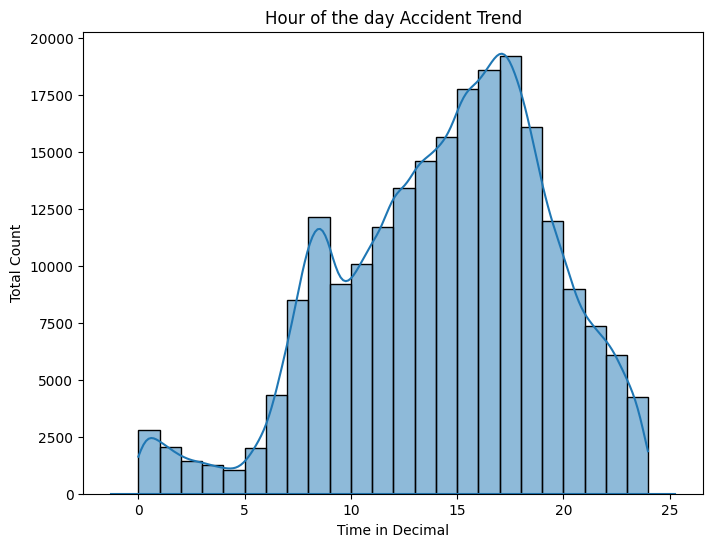

In [61]:
hist_generator(data['decimal_time'],'Hour of the day Accident Trend','Total Count', 'Time in Decimal', 1, kde=True)

In [62]:
# Obtain statistical info of the column for more insight

data['decimal_time'].describe()

count    220435.000000
mean         14.332526
std           4.965627
min           0.000000
25%          11.000000
50%          15.000000
75%          17.950000
max          23.983333
Name: decimal_time, dtype: float64

In [63]:
# Obtain statistical info of the column for more insight

new_df = data['decimal_time'].value_counts()

hour_of_day = pd.DataFrame(new_df)
hour_of_day

decimal_time
17.000000          1974
15.000000          1758
16.000000          1752
17.500000          1734
18.000000          1678
...                 ...
4.516667              2
3.766667              2
4.650000              1
4.550000              1
4.966667              1

[1438 rows x 1 columns]

#### day of the week

In [64]:
data['day_of_week'].value_counts()

6    35938
5    33447
4    32692
3    31491
2    30677
7    30530
1    25660
Name: day_of_week, dtype: int64

In [65]:
data['day_of_week'].describe()

count    220435.000000
mean          4.122884
std           1.944851
min           1.000000
25%           2.000000
50%           4.000000
75%           6.000000
max           7.000000
Name: day_of_week, dtype: float64

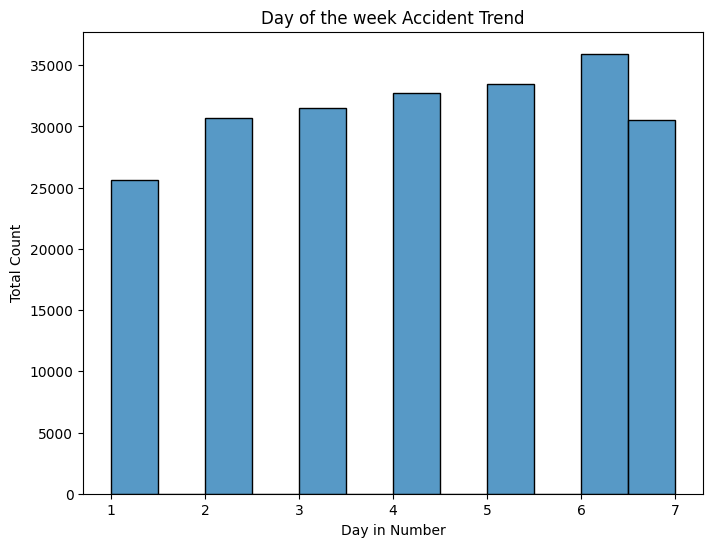

In [66]:
# Plot a histogram showing this column

image2 = hist_generator(data['day_of_week'], 'Day of the week Accident Trend','Total Count', 'Day in Number', 0.5, kde=False)

In [67]:
# Location where accident occurs the most at the above time and day based on local_authority_ons_district

data.query('decimal_time == 17.0 and day_of_week == 6').local_authority_ons_district.value_counts()

E08000012    21
E08000025    20
E08000018    12
E06000021    10
S12000036     9
             ..
E06000040     1
E07000144     1
E07000147     1
E07000102     1
E07000139     1
Name: local_authority_ons_district, Length: 122, dtype: int64

In [68]:
# Generate a dataframe for the above question to gain more insight
detail_df = data.query('decimal_time == 17.0 and day_of_week == 6')
pd.DataFrame(detail_df.groupby(['light_conditions', 'weather_conditions', 'road_surface_conditions', 'special_conditions_at_site']).local_authority_ons_district.value_counts().nlargest(5))

local_authority_ons_district
light_conditions weather_conditions road_surface_conditions special_conditions_at_site local_authority_ons_district                              
1                1                  1                       0                          E08000012                                               21
                                                                                       E08000025                                               20
4                1                  1                       0                          E08000018                                               12
                                    2                       0                          E06000021                                               10
1                1                  1                       0                          E06000050                                                8

In [69]:
# Location where accident occurs the most at the above time and day based on local_authority_ons_district

# Generate a dataframe for the above question to gain more insight
detail_df = data.query('decimal_time == 17.0 and day_of_week == 6')
pd.DataFrame(detail_df.groupby(['accident_severity', 'speed_limit', 'junction_detail', 'sex_of_driver']).local_authority_ons_district.value_counts().nlargest(5))

local_authority_ons_district
accident_severity speed_limit junction_detail sex_of_driver local_authority_ons_district                              
3                 30          3               1             E08000012                                                9
                              5               3             E08000012                                                9
                  70          0               1             E08000025                                                8
1                 70          3               1             S12000034                                                6
3                 30          1               1             E08000025                                                6

In [70]:
# Total number of accidents occurring at this time and on friday

print(f'Total number of accidents at 17:00 and on a Friday was {len(detail_df)}')

Total number of accidents at 17:00 and on a Friday was 422


### 2. For motorbikes, are there significant hours of the day, and days of the week, on which accidents occur? We suggest a focus on: Motorcycle 125cc and under, Motorcycle over 125cc and up to 500cc, and Motorcycle over 500cc

#### a. Motorcycle 125cc and under

In [71]:
# vehicle_type == 3 or 2

under_125 = data[((data['vehicle_type'] == 3) | (data['vehicle_type'] == 2))]

under_125.decimal_time.value_counts()

17.000000    95
15.500000    86
17.500000    84
19.000000    84
16.500000    81
             ..
8.183333      1
4.250000      1
19.350000     1
3.083333      1
11.533333     1
Name: decimal_time, Length: 1166, dtype: int64

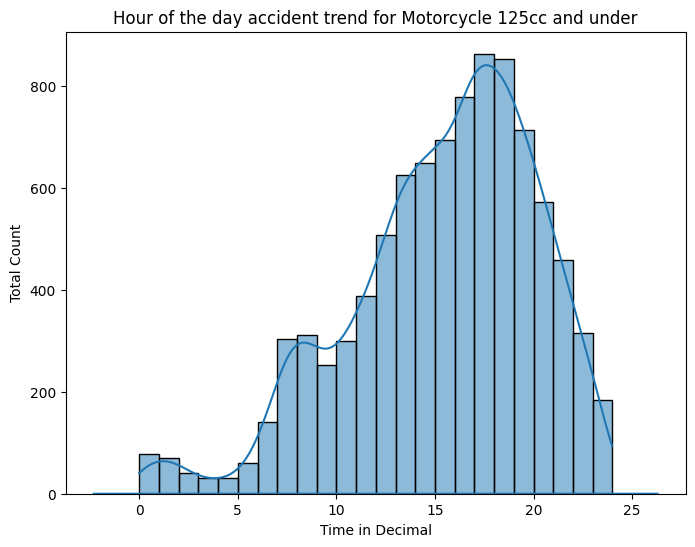

In [72]:
#Plot a histplot of Relationship to vehicle_type against time

image3 = hist_generator(under_125['decimal_time'],'Hour of the day accident trend for Motorcycle 125cc and under','Total Count', 'Time in Decimal', 1, kde=True)

#### day_of_week

In [73]:
# Day of the week

under_125.day_of_week.value_counts()

6    1568
5    1481
4    1323
7    1305
3    1269
2    1258
1    1016
Name: day_of_week, dtype: int64

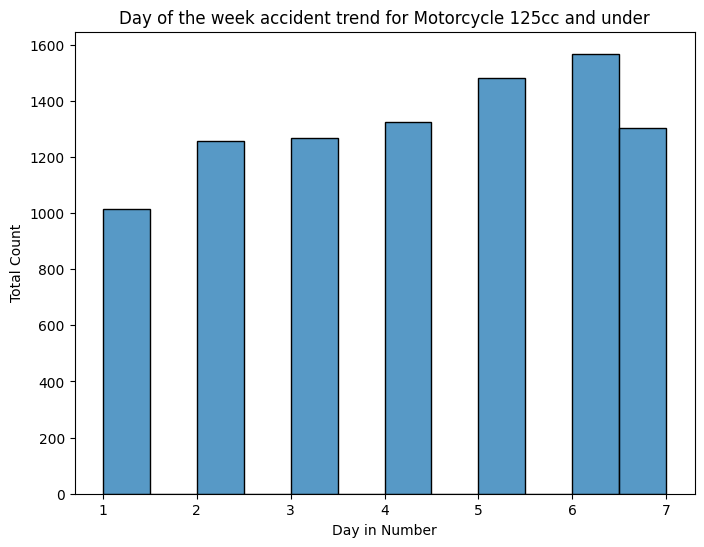

In [74]:
#Plot a histplot of Relationship to vehicle_type against day of the week

image4 = hist_generator(under_125['day_of_week'],'Day of the week accident trend for Motorcycle 125cc and under','Total Count', 'Day in Number', 0.5, kde=False)

In [75]:
# Generate a dataframe for the above question to gain more insight
df_125 = under_125.query('decimal_time == 17.0 and day_of_week == 6')

pd.DataFrame(df_125.groupby(['light_conditions', 'weather_conditions', 'road_surface_conditions', 'special_conditions_at_site']).local_authority_ons_district.value_counts().nlargest(5))

local_authority_ons_district
light_conditions weather_conditions road_surface_conditions special_conditions_at_site local_authority_ons_district                              
1                1                  1                       0                          E07000038                                                2
                                                                                       E06000038                                                1
                                                                                       E07000106                                                1
                                                                                       E08000016                                                1
                                                                                       E08000032                                                1

In [76]:
# Total number of accidents occurring at this time and on friday

print(f'Total number of accidents at 17:00 and on a Friday was {len(df_125)}')

Total number of accidents at 17:00 and on a Friday was 20


In [77]:
pd.DataFrame(df_125.groupby(['accident_severity', 'speed_limit', 'junction_detail', 'sex_of_driver']).local_authority_ons_district.value_counts().nlargest(5))

local_authority_ons_district
accident_severity speed_limit junction_detail sex_of_driver local_authority_ons_district                              
3                 30          0               1             E09000032                                                2
2                 30          8               1             E07000038                                                1
                                                            E08000014                                                1
                  70          0               1             E08000016                                                1
3                 30          0               1             E06000038                                                1

#### b. Motorcycle over 125cc and up to 500cc

In [78]:
# vehicle_type == 4

over_125 = data[(data['vehicle_type'] == 4)]

over_125.decimal_time.value_counts()

17.000000    26
16.500000    24
15.500000    22
16.000000    19
15.000000    16
             ..
3.583333      1
16.650000     1
6.850000      1
12.316667     1
9.666667      1
Name: decimal_time, Length: 685, dtype: int64

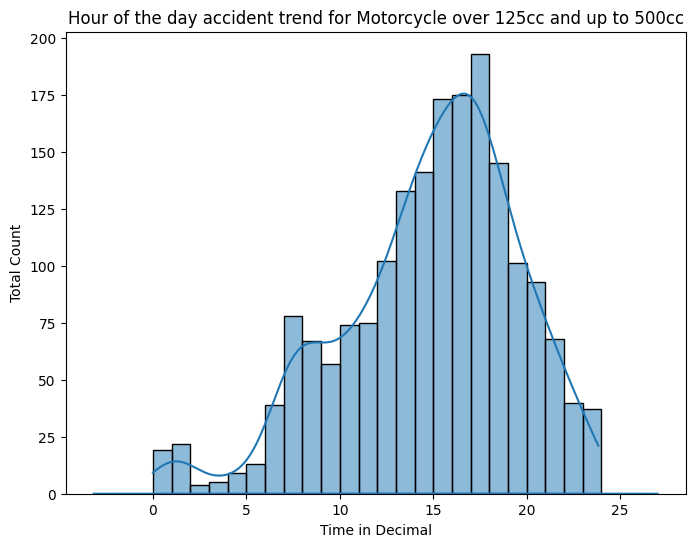

In [79]:
#Plot a histplot of Relationship to vehicle_type against time

image5 = hist_generator(over_125['decimal_time'],'Hour of the day accident trend for Motorcycle over 125cc and up to 500cc','Total Count', 'Time in Decimal', 1, kde=True)

#### day_of_week

In [80]:
# Day of the week

over_125.day_of_week.value_counts()

6    297
5    280
4    268
7    258
3    254
1    254
2    252
Name: day_of_week, dtype: int64

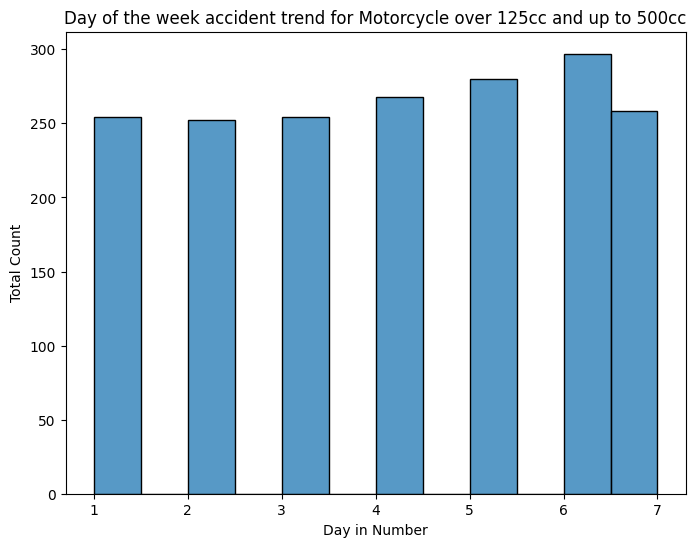

In [81]:
#Plot a histplot of Relationship to vehicle_type against day of the week

image6 = hist_generator(over_125['day_of_week'],'Day of the week accident trend for Motorcycle over 125cc and up to 500cc','Total Count', 'Day in Number', 0.5, kde=False)

In [82]:
# Generate a dataframe for the above question to gain more insight
df_ = over_125.query('decimal_time == 17.0 and day_of_week == 6')

pd.DataFrame(df_.groupby(['light_conditions', 'weather_conditions', 'road_surface_conditions', 'special_conditions_at_site']).local_authority_ons_district.value_counts().nlargest(5))

local_authority_ons_district
light_conditions weather_conditions road_surface_conditions special_conditions_at_site local_authority_ons_district                              
1                1                  1                       0                          E06000023                                                1
                                                                                       E07000111                                                1
4                1                  2                       0                          E09000007                                                1
                 2                  2                       0                          E06000037                                                1

In [83]:
# Total number of accidents occurring at this time and on friday

print(f'Total number of accidents at 17:00 and on a Friday was {len(df_)}')

Total number of accidents at 17:00 and on a Friday was 4


In [84]:
pd.DataFrame(df_.groupby(['accident_severity', 'speed_limit', 'junction_detail', 'sex_of_driver']).local_authority_ons_district.value_counts().nlargest(5))

local_authority_ons_district
accident_severity speed_limit junction_detail sex_of_driver local_authority_ons_district                              
3                 20          3               1             E06000023                                                1
                  30          0               1             E09000007                                                1
                              1               1             E06000037                                                1
                  40          3               1             E07000111                                                1

#### c. Motorcycle over 500cc

In [85]:
# Vehicle type == 5

over_500 = data[(data['vehicle_type'] == 5)]

over_500.decimal_time.value_counts()

17.500000    46
14.000000    43
13.500000    41
17.000000    40
12.000000    38
             ..
9.916667      1
16.933333     1
19.083333     1
11.433333     1
12.316667     1
Name: decimal_time, Length: 913, dtype: int64

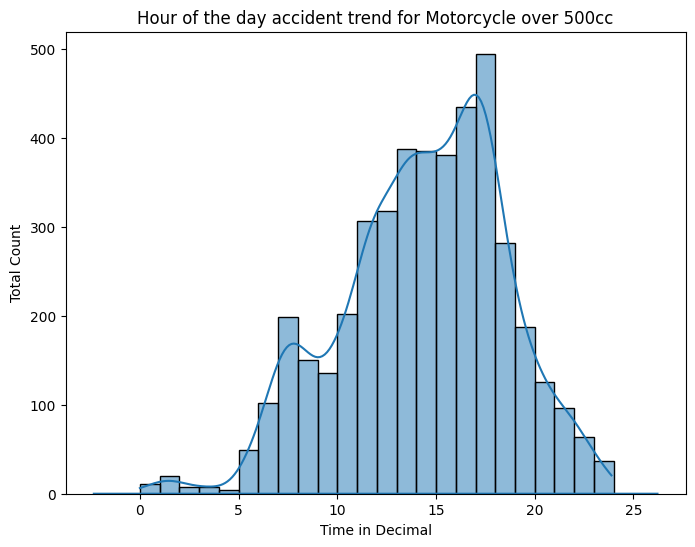

In [86]:
#Plot a histplot of Relationship to vehicle_type against time

image5 = hist_generator(over_500['decimal_time'],'Hour of the day accident trend for Motorcycle over 500cc','Total Count', 'Time in Decimal', 1, kde=True)

#### day_of_week

In [87]:
# Day of the week

over_500.day_of_week.value_counts()

1    830
7    653
6    645
5    578
4    576
3    569
2    542
Name: day_of_week, dtype: int64

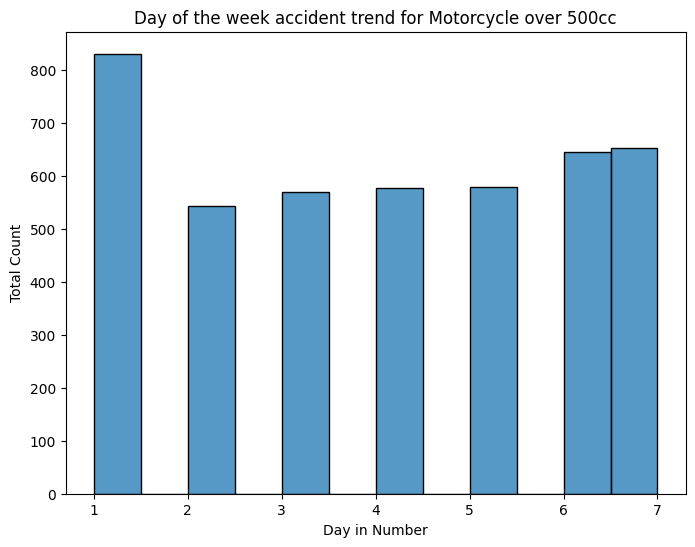

In [88]:
#Plot a histplot of Relationship to vehicle_type against day of the week

image6 = hist_generator(over_500['day_of_week'],'Day of the week accident trend for Motorcycle over 500cc','Total Count', 'Day in Number', 0.5, kde=False)

In [89]:
# Generate a dataframe for the above question to gain more insight
df_500 = over_500.query('decimal_time == 17.5 and day_of_week == 1')

pd.DataFrame(df_500.groupby(['light_conditions', 'weather_conditions', 'road_surface_conditions', 'special_conditions_at_site']).local_authority_ons_district.value_counts().nlargest(5))

local_authority_ons_district
light_conditions weather_conditions road_surface_conditions special_conditions_at_site local_authority_ons_district                              
1                1                  1                       0                          E07000045                                                1

In [90]:
pd.DataFrame(df_500.groupby(['accident_severity', 'speed_limit', 'junction_detail', 'sex_of_driver']).local_authority_ons_district.value_counts().nlargest(5))

local_authority_ons_district
accident_severity speed_limit junction_detail sex_of_driver local_authority_ons_district                              
3                 30          0               1             E07000045                                                1

In [91]:
# Total number of accidents occurring at this time and on sunday

print(f'Total number of accidents at 17:30 and on a Sunday was {len(df_500)}')

Total number of accidents at 17:30 and on a Sunday was 1


#### Combination of all 3 conditions

In [92]:
selected_motorbikes = data[(((data['vehicle_type'] == 3) | (data['vehicle_type'] == 2)) | (data['vehicle_type'] == 4)\
 | (data['vehicle_type'] == 5))]

selected_motorbikes.decimal_time.value_counts()

17.000000    161
17.500000    144
15.500000    140
16.500000    136
16.000000    129
            ... 
3.450000       1
9.450000       1
0.816667       1
3.933333       1
9.866667       1
Name: decimal_time, Length: 1249, dtype: int64

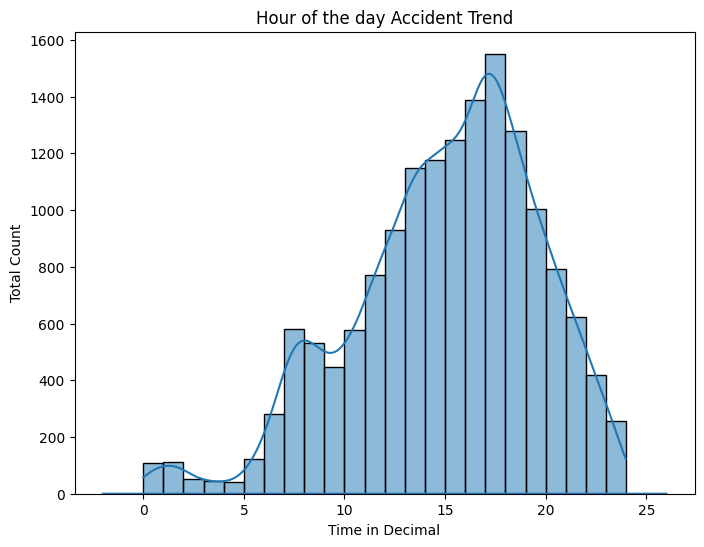

In [93]:
#Plot a histplot of Relationship to selected motorbikes against time

image3 = hist_generator(selected_motorbikes['decimal_time'],'Hour of the day Accident Trend','Total Count', 'Time in Decimal', 1, kde=True)

In [94]:
selected_motorbikes.day_of_week.value_counts()

6    2510
5    2339
7    2216
4    2167
1    2100
3    2092
2    2052
Name: day_of_week, dtype: int64

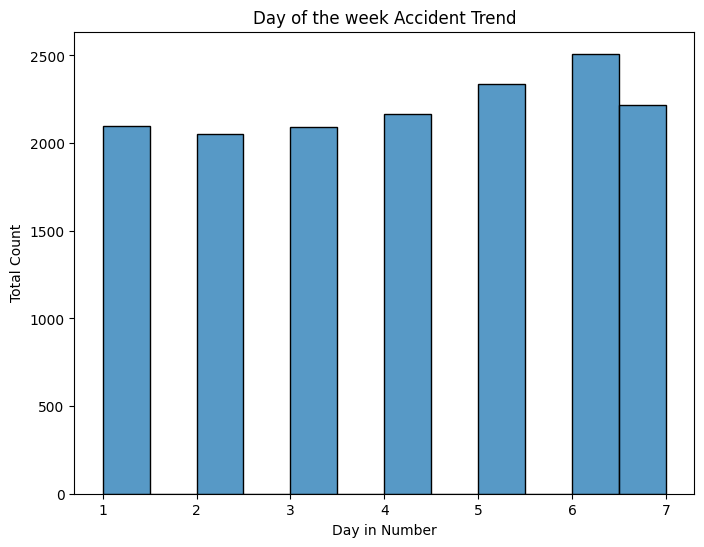

In [95]:
# Plot the histogram

image4 = hist_generator(selected_motorbikes.day_of_week, 'Day of the week Accident Trend','Total Count', 'Day in Number', 0.5, kde=False)

In [96]:
# Location where accident occurs the most at the above time and day based on local_authority_ons_district

selected_motorbikes.query('decimal_time == 17.0 and day_of_week == 6').local_authority_ons_district.value_counts()

E09000006    2
E09000032    2
E09000007    2
E07000038    2
E08000016    1
W06000023    1
E06000023    1
E06000026    1
E07000111    1
E07000106    1
E06000037    1
E06000039    1
E06000038    1
E08000032    1
E08000034    1
E09000005    1
E08000014    1
E08000013    1
E09000015    1
E09000021    1
E09000022    1
E09000014    1
E09000031    1
E09000008    1
S12000033    1
Name: local_authority_ons_district, dtype: int64

In [97]:
# Generate a dataframe for the above question to gain more insight
motorbikes_df = selected_motorbikes.query('decimal_time == 17.0 and day_of_week == 6')

pd.DataFrame(motorbikes_df.groupby(['light_conditions', 'weather_conditions', 'road_surface_conditions', 'special_conditions_at_site']).local_authority_ons_district.value_counts().nlargest(5))

local_authority_ons_district
light_conditions weather_conditions road_surface_conditions special_conditions_at_site local_authority_ons_district                              
1                1                  1                       0                          E07000038                                                2
                                                                                       E06000023                                                1
                                                                                       E06000026                                                1
                                                                                       E06000038                                                1
                                                                                       E06000039                                                1

In [98]:
pd.DataFrame(motorbikes_df.groupby(['accident_severity', 'speed_limit', 'junction_detail', 'sex_of_driver']).local_authority_ons_district.value_counts().nlargest(5))

local_authority_ons_district
accident_severity speed_limit junction_detail sex_of_driver local_authority_ons_district                              
3                 30          0               1             E09000032                                                2
2                 30          8               1             E07000038                                                1
                                                            E08000014                                                1
                  60          3               1             W06000023                                                1
                  70          0               1             E08000016                                                1

### 3. For pedestrians involved in accidents, are there significant hours of the day, and days of the week, on which they are more likely to be involved?

In [99]:
# Pedestrian in casualty_class = 3

data[data['casualty_class'] == 3].decimal_time.value_counts()

15.500000    197
15.000000    173
16.000000    166
17.000000    159
16.500000    159
            ... 
0.283333       1
2.066667       1
21.183333      1
23.533333      1
6.150000       1
Name: decimal_time, Length: 1264, dtype: int64

In [100]:
data[data['casualty_class'] == 3].casualty_class.count()

16010

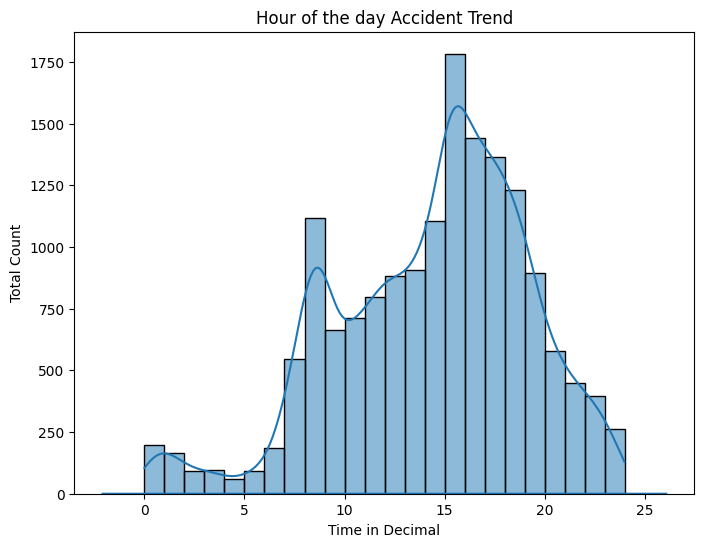

In [101]:
# Plot a histogram showing this column

image5 = hist_generator(data[data['casualty_class'] == 3].decimal_time,'Hour of the day Accident Trend','Total Count', 'Time in Decimal', 1, kde=True)

In [102]:
#Value counts based on day of the week

data[data['casualty_class'] == 3].day_of_week.value_counts()

6    2764
5    2577
3    2439
4    2433
2    2372
7    2059
1    1366
Name: day_of_week, dtype: int64

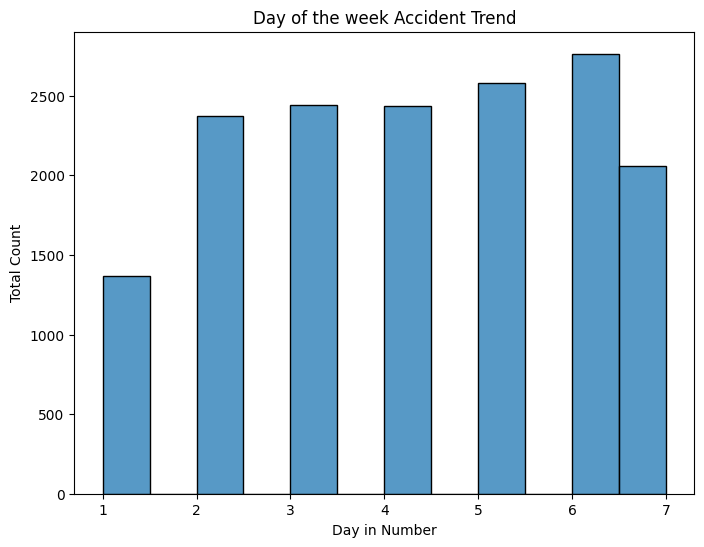

In [103]:
# Plot a histogram showing this column

image6 = hist_generator(data[data['casualty_class'] == 3].day_of_week, 'Day of the week Accident Trend','Total Count', 'Day in Number', 0.5, kde=False)

In [104]:
# Generate a dataframe for the above question to gain more insight
pedestrian_df = data.query('casualty_class == 3 and decimal_time == 15.5 and day_of_week == 6')

pd.DataFrame(pedestrian_df.groupby(['light_conditions', 'weather_conditions', 'road_surface_conditions', 'special_conditions_at_site']).local_authority_ons_district.value_counts().nlargest(5))

local_authority_ons_district
light_conditions weather_conditions road_surface_conditions special_conditions_at_site local_authority_ons_district                              
1                1                  1                       0                          E06000004                                                1
                                                                                       E06000029                                                1
                                                                                       E06000030                                                1
                                                                                       E06000044                                                1
                                                                                       E07000075                                                1

In [105]:
pd.DataFrame(pedestrian_df.groupby(['accident_severity', 'speed_limit', 'junction_detail', 'sex_of_driver']).local_authority_ons_district.value_counts().nlargest(5))

local_authority_ons_district
accident_severity speed_limit junction_detail sex_of_driver local_authority_ons_district                              
2                 20          6               1             E09000007                                                1
                  30          0               1             E08000015                                                1
                                              2             E07000075                                                1
                                                            E07000234                                                1
                                                            W06000015                                                1

In [106]:
# Total number of accidents occurring at this time and on friday

print(f'Total number of accidents at 15:30 and on a Friday was {len(pedestrian_df)}')

Total number of accidents at 15:30 and on a Friday was 30


### 4. Using the apriori algorithm, explore the impact of selected variables on accident severity

In [107]:
# Drop time and converted since we have decimal_time. Also drop irrelevant columns from the dataset
# junction location and details are correlated and contains similar class, hence, we drop

data.drop(['converted_time', 'time', 'accident_index', 'vehicle_index', 'casualty_index', 'accident_year_x',
           'accident_reference_x', 'vehicle_reference_x', 'casualty_reference',  'accident_year_y', 'accident_reference_y',
          'vehicle_reference_y',  'accident_year','accident_reference', 'date', 'age_band_of_casualty', 'junction_location'], axis=1, inplace=True)

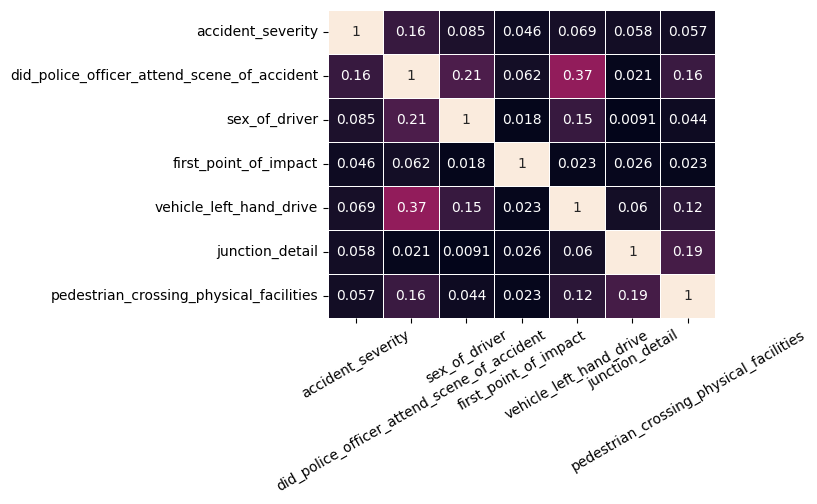

In [108]:
# Heatmap to select variables that highly correlated
# Each were compared against accident_severity before the following were chosen

sel_data = data[['accident_severity', 'did_police_officer_attend_scene_of_accident', 'sex_of_driver','first_point_of_impact',
                'vehicle_left_hand_drive', 'junction_detail', 'pedestrian_crossing_physical_facilities']]
plt.subplots(figsize=(5,4))
sns.heatmap(sel_data.corr(),annot=True, cbar=False, linewidths=0.5)
plt.xticks(rotation=30);

In [109]:
#Selected columns of importance was used based on correlation
apriori_accident = data[['accident_severity', 'did_police_officer_attend_scene_of_accident', 'sex_of_driver','first_point_of_impact',
                'vehicle_left_hand_drive', 'junction_detail', 'pedestrian_crossing_physical_facilities']]

#### One-hot encode
a_severity = pd.get_dummies(apriori_accident.accident_severity, prefix='severity')
a_police = pd.get_dummies(apriori_accident.did_police_officer_attend_scene_of_accident, prefix='police')
a_ped = pd.get_dummies(apriori_accident.pedestrian_crossing_physical_facilities, prefix='pedestrian')
a_driver = pd.get_dummies(apriori_accident.sex_of_driver, prefix='driver')
a_impact = pd.get_dummies(apriori_accident.first_point_of_impact, prefix='impact')
a_junction = pd.get_dummies(apriori_accident.junction_detail, prefix='junction')
a_left = pd.get_dummies(apriori_accident.vehicle_left_hand_drive, prefix='left')

In [110]:
# Merge all together

acc = pd.concat([a_severity, a_police, a_driver, a_impact, a_junction, a_left, a_ped], axis=1)

In [111]:
#Estimating support
support = apriori(acc, min_support=0.019, use_colnames=True)


support.head(20)

support      itemsets
0   0.019194  (severity_1)
1   0.203362  (severity_2)
2   0.777445  (severity_3)
3   0.720126    (police_1)
4   0.194720    (police_2)
5   0.085154    (police_3)
6   0.638224    (driver_1)
7   0.260362    (driver_2)
8   0.101413    (driver_3)
9   0.060072    (impact_0)
10  0.506113    (impact_1)
11  0.169333    (impact_2)
12  0.133736    (impact_3)
13  0.130746    (impact_4)
14  0.436936  (junction_0)
15  0.075528  (junction_1)
16  0.266119  (junction_3)
17  0.029596  (junction_5)
18  0.093719  (junction_6)
19  0.020156  (junction_8)

In [112]:
# Create a class to estimate the metrics of interest
class apriori_metrics:
    def __init__(self, table, metric, threshold_min):
        self.table = table
        self.metric = metric
        self.threshold_min = threshold_min
    # Create the metrics estimator
    def metrics_estimator(self):
        new_rule = association_rules(self.table, self.metric, self.threshold_min)
        return new_rule
conf = apriori_metrics(support, 'confidence', 0.2)
confidence = conf.metrics_estimator()
confidence

antecedents  \
0                         (severity_1)   
1                         (severity_2)   
2                           (police_1)   
3                         (severity_2)   
4                           (driver_1)   
...                                ...   
9690  (junction_0, police_1, driver_2)   
9691      (impact_1, left_1, driver_2)   
9692    (impact_1, police_1, driver_2)   
9693            (junction_0, driver_2)   
9694              (impact_1, driver_2)   

                                            consequents  antecedent support  \
0                                              (left_1)            0.019194   
1                                            (police_1)            0.203362   
2                                          (severity_2)            0.720126   
3                                            (driver_1)            0.203362   
4                                          (severity_2)            0.638224   
...                                                 ...                 ...   
9690       (impact_1, pedestrian_0, severity_3, left_1)            0.080015   
9691   (pedestrian_0, severity_3, police_1, junction_0)            0.123134   
9692     (pedestrian_0, severity_3, left_1, junction_0)            0.099517   
9693  (pedestrian_0, severity_3, impact_1, left_1, p...            0.109524   
9694  (pedestrian_0, severity_3, junction_0, left_1,...            0.125307   

      consequent support   support  confidence      lift  leverage  \
0               0.961835  0.019103    0.995273  1.034765  0.000642   
1               0.720126  0.170164    0.836754  1.161955  0.023718   
2               0.203362  0.170164    0.236297  1.161955  0.023718   
3               0.638224  0.142541    0.700924  1.098240  0.012751   
4               0.203362  0.142541    0.223340  1.098240  0.012751   
...                  ...       ...         ...       ...       ...   
9690            0.290807  0.027001    0.337453  1.160403  0.003732   
9691            0.203715  0.027001    0.219283  1.076419  0.001917   
9692            0.278436  0.027001    0.271322  0.974452 -0.000708   
9693            0.221072  0.027001    0.246531  1.115162  0.002788   
9694            0.202046  0.027001    0.215480  1.066492  0.001683   

      conviction  zhangs_metric  
0       8.073900       0.034255  
1       1.714428       0.174962  
2       1.043126       0.498014  
3       1.209642       0.112287  
4       1.025723       0.247259  
...          ...            ...  
9690    1.070405       0.150253  
9691    1.019940       0.080963  
9692    0.990238      -0.028291  
9693    1.033789       0.115971  
9694    1.017124       0.071278  

[9695 rows x 10 columns]

In [113]:
#Class generator
class confidence_severity:
    def __init__(self, table, name_col):
        self.table = table # dataframe
        self.name_col = name_col #Column name
    def severity(self):
        # Create an empty list
        list_ = []

        #Iterate thru the confidence table
        for i, j in self.table.iterrows(): 

            #Create an empty list
            severity = []
            for p in list(j[self.name_col]):
               # if severity is contained in column consequent, append true to the empty list 
                if 'severity' in p:
                    severity.append(True)
                else:
                    severity.append(False)
            if True in severity:
                list_.append(True)
            else:
                list_.append(False)
        return list_

sev = confidence_severity(confidence, 'consequents')
severity_list = sev.severity()

In [114]:
# Call the class
confidence['severity'] = severity_list
new = confidence[confidence.severity == True]

new.head(20)

antecedents   consequents  antecedent support  consequent support  \
2       (police_1)  (severity_2)            0.720126            0.203362   
4       (driver_1)  (severity_2)            0.638224            0.203362   
6       (impact_1)  (severity_2)            0.506113            0.203362   
8       (impact_3)  (severity_2)            0.133736            0.203362   
9     (junction_0)  (severity_2)            0.436936            0.203362   
13        (left_1)  (severity_2)            0.961835            0.203362   
14  (pedestrian_0)  (severity_2)            0.794402            0.203362   
17      (police_1)  (severity_3)            0.720126            0.777445   
18      (police_2)  (severity_3)            0.194720            0.777445   
20      (police_3)  (severity_3)            0.085154            0.777445   
22      (driver_1)  (severity_3)            0.638224            0.777445   
24      (driver_2)  (severity_3)            0.260362            0.777445   
25      (driver_3)  (severity_3)            0.101413            0.777445   
26      (impact_0)  (severity_3)            0.060072            0.777445   
27      (impact_1)  (severity_3)            0.506113            0.777445   
29      (impact_2)  (severity_3)            0.169333            0.777445   
30      (impact_3)  (severity_3)            0.133736            0.777445   
31      (impact_4)  (severity_3)            0.130746            0.777445   
32    (junction_0)  (severity_3)            0.436936            0.777445   
34    (junction_1)  (severity_3)            0.075528            0.777445   

     support  confidence      lift  leverage  conviction  zhangs_metric  \
2   0.170164    0.236297  1.161955  0.023718    1.043126       0.498014   
4   0.142541    0.223340  1.098240  0.012751    1.025723       0.247259   
6   0.113916    0.225080  1.106795  0.010992    1.028026       0.195369   
8   0.028521    0.213263  1.048690  0.001324    1.012586       0.053597   
9   0.098959    0.226484  1.113700  0.010103    1.029892       0.181315   
13  0.200531    0.208488  1.025208  0.004931    1.006477       0.644243   
14  0.170935    0.215174  1.058087  0.009384    1.015051       0.267015   
17  0.532756    0.739809  0.951590 -0.027102    0.855354      -0.153811   
18  0.164057    0.842532  1.083720  0.012674    1.413337       0.095932   
20  0.080631    0.946886  1.217947  0.014429    4.190158       0.195602   
22  0.480686    0.753161  0.968765 -0.015498    0.901623      -0.081829   
24  0.210475    0.808391  1.039806  0.008057    1.161510       0.051758   
25  0.086284    0.850816  1.094376  0.007441    1.491822       0.095969   
26  0.045419    0.756079  0.972518 -0.001283    0.912408      -0.029187   
27  0.380475    0.751759  0.966962 -0.013000    0.896530      -0.064704   
29  0.144083    0.850885  1.094464  0.012436    1.492513       0.103906   
30  0.102579    0.767028  0.986602 -0.001393    0.955290      -0.015434   
31  0.104888    0.802228  1.031877  0.003240    1.125310       0.035539   
32  0.324962    0.743729  0.956633 -0.014732    0.868438      -0.074513   
34  0.064055    0.848099  1.090880  0.005336    1.465134       0.090115   

    severity  
2       True  
4       True  
6       True  
8       True  
9       True  
13      True  
14      True  
17      True  
18      True  
20      True  
22      True  
24      True  
25      True  
26      True  
27      True  
29      True  
30      True  
31      True  
32      True  
34      True

In [115]:
lift = apriori_metrics(support, 'lift', 0.5)
lift = lift.metrics_estimator()
lift

antecedents                                        consequents  \
0          (left_1)                                       (severity_1)   
1      (severity_1)                                           (left_1)   
2      (severity_2)                                         (police_1)   
3        (police_1)                                       (severity_2)   
4        (police_2)                                       (severity_2)   
...             ...                                                ...   
17499  (junction_0)  (pedestrian_0, severity_3, impact_1, left_1, p...   
17500    (impact_1)  (pedestrian_0, severity_3, junction_0, left_1,...   
17501      (left_1)  (pedestrian_0, severity_3, junction_0, impact_...   
17502    (police_1)  (pedestrian_0, severity_3, junction_0, impact_...   
17503    (driver_2)  (pedestrian_0, severity_3, junction_0, impact_...   

       antecedent support  consequent support   support  confidence      lift  \
0                0.961835            0.019194  0.019103    0.019861  1.034765   
1                0.019194            0.961835  0.019103    0.995273  1.034765   
2                0.203362            0.720126  0.170164    0.836754  1.161955   
3                0.720126            0.203362  0.170164    0.236297  1.161955   
4                0.194720            0.203362  0.028684    0.147310  0.724376   
...                   ...                 ...       ...         ...       ...   
17499            0.436936            0.061016  0.027001    0.061797  1.012798   
17500            0.506113            0.054497  0.027001    0.053350  0.978958   
17501            0.961835            0.027105  0.027001    0.028073  1.035678   
17502            0.720126            0.034164  0.027001    0.037495  1.097493   
17503            0.260362            0.100905  0.027001    0.103706  1.027759   

       leverage  conviction  zhangs_metric  
0      0.000642    1.000681       0.880305  
1      0.000642    8.073900       0.034255  
2      0.023718    1.714428       0.174962  
3      0.023718    1.043126       0.498014  
4     -0.010914    0.934265      -0.320884  
...         ...         ...            ...  
17499  0.000341    1.000832       0.022442  
17500 -0.000580    0.998789      -0.041706  
17501  0.000930    1.000995       0.902614  
17502  0.002399    1.003461       0.317401  
17503  0.000729    1.003125       0.036517  

[17504 rows x 10 columns]

### Identify accidents in our region: Kingston upon Hull, Humberside, and the East Riding of Yorkshire etc. You can do this by filtering on LSOA, or police region or another method if you can find one. Run clustering on this data. What do these clusters reveal about the distribution of accidents in our region?

#### a. Kingston upon Hull

In [116]:
# Kingston upon Hull = 'E06000010' in the local_authority_ons_district, hence, filtering becomes

hull = data[data.local_authority_ons_district == 'E06000010']

# Time of the day in which the most accidents occurred

hull.decimal_time.value_counts()

16.500000    19
15.133333    16
18.166667    15
18.500000    13
15.833333    13
             ..
10.750000     1
18.116667     1
23.500000     1
16.850000     1
2.566667      1
Name: decimal_time, Length: 376, dtype: int64

In [117]:
# Day of the week in which the most accidents occurred

hull.day_of_week.value_counts()

4    250
6    221
2    214
3    187
5    176
7    169
1    119
Name: day_of_week, dtype: int64

In [118]:
# Percentage of accidents in hull against the total number of accidents

total_no_accidents = len(data)
len_hull = len(hull)

percentage_hull = (len_hull/total_no_accidents)*100

print(f'The total number of accidents that occurred in hull were {len_hull}, i.e., {percentage_hull:.2f}% of total accidents')

The total number of accidents that occurred in hull were 1336, i.e., 0.61% of total accidents


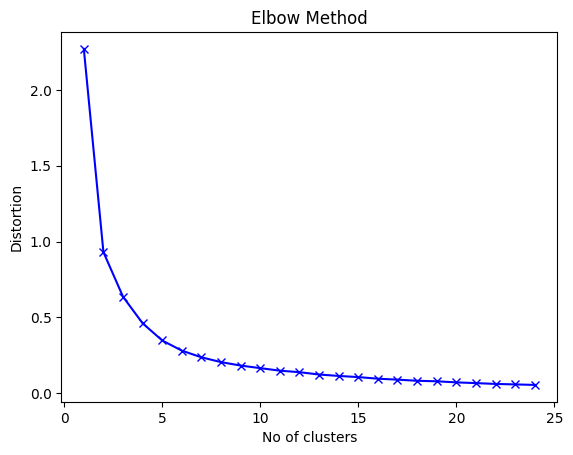

In [119]:
# Create a class instance to estimate k value using elbow method
hull = data[data.local_authority_ons_district == 'E06000010']
class K_value_estimator:
    def __init__(self, table):
        self.table = table
    # Estimate K value
    def k_estimator(self):
        dist=[]
        K=range(1,25)
        for k in K:
            kmeans=KMeans(n_clusters=k,random_state=42)
            kmeans.fit(self.table)
            dist.append(kmeans.inertia_)
        plt.plot(K, dist, 'bx-')
        plt.xlabel('No of clusters')
        plt.ylabel('Distortion')
        plt.title('Elbow Method')
        plt.show()
    
k_val = K_value_estimator(hull[['longitude', 'latitude']])
k_val.k_estimator()

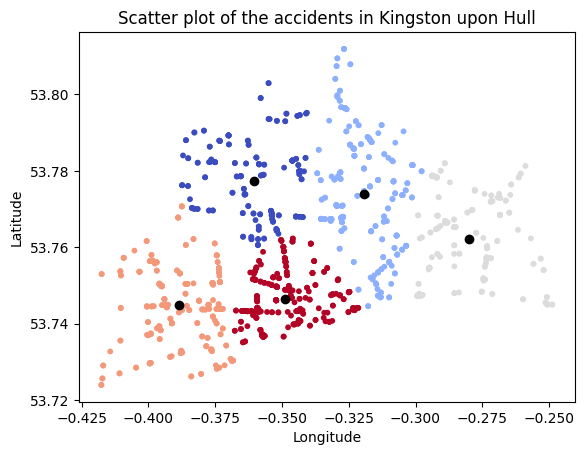

In [120]:
# Create a class instance to estimate k value using elbow method
hull = data[data.local_authority_ons_district == 'E06000010']
class Kmeans_estimator:
    def __init__(self, table, t, var_p, var_q):
        self.table = table
        self.t = t
        self.var_p = var_p
        self.var_q = var_q
    
    def kmeans_clustering(self):
        # Using Kmeans clustering

        kmeans = KMeans(n_clusters=5)
        kmeans.fit(self.table)

        labels = kmeans.predict(self.table)
        centroids = kmeans.cluster_centers_

        plt.scatter(self.var_p,self.var_q, c = labels, cmap = 'coolwarm', s=10)

        plt.scatter(centroids[:,0], centroids[:,1], color='black')

        plt.title(self.t)
        plt.ylabel('Latitude')
        plt.xlabel('Longitude')

        plt.show()

# Callback the class instance
hull = Kmeans_estimator(hull[['longitude', 'latitude']],'Scatter plot of the accidents in Kingston upon Hull',hull['longitude'], hull['latitude'])
hull.kmeans_clustering()

#### Using folium Library

In [121]:
#Kmeans cluster
hull = data[data.local_authority_ons_district == 'E06000010']
kmeans = KMeans(n_clusters=5)
kmeans.fit(hull[['longitude', 'latitude']])
hull['label'] = kmeans.fit_predict(hull[['longitude', 'latitude']])

#Obtain mean of latitude and longitude
lat_mean = np.mean(hull['latitude'])
long_mean = np.mean(hull['longitude'])

# Center of the map
center = [lat_mean, long_mean]

#Fit in the map and cluster marker
hull_map = folium.Map(location=center, zoom_start=10)
marker = folium.plugins.MarkerCluster().add_to(hull_map)

#Iterate thru the dataframe
for i, j in hull.iterrows():
    folium.Marker([j['latitude'], j['longitude']], popup=f"{j['label']}").add_to(marker)

hull_map.save('hull_map.html')
hull_map

Github.io. (2018). folium — Folium 0.14.0 documentation. [online] Available at: https://python-visualization.github.io/folium/modules.html# [Accessed 31 Jul. 2023].

#### b. Humberside

In [122]:
# Humberside = 16 in the local_authority_ons_district, hence, filtering becomes

Humberside = data[data.police_force == 16]

In [123]:
Humberside.decimal_time.value_counts()

16.500000    45
17.500000    43
17.000000    39
11.500000    38
18.500000    34
             ..
12.416667     1
6.766667      1
22.266667     1
23.183333     1
2.566667      1
Name: decimal_time, Length: 707, dtype: int64

In [124]:
Humberside.day_of_week.value_counts()

6    655
4    653
3    608
2    604
7    588
5    533
1    424
Name: day_of_week, dtype: int64

In [125]:
avg_acc = (len(Humberside))/7
print(f'An average of {avg_acc:.2f} take place every day in Humberside')

An average of 580.71 take place every day in Humberside


In [126]:
hum_hull = ((Humberside[data.local_authority_ons_district == 'E06000010'].day_of_week.count())/len(Humberside))*100

print(f'Hull make up {hum_hull:.2f}% of the total accidents in Humberside')

Hull make up 32.87% of the total accidents in Humberside


In [127]:
Humberside[data.accident_severity == 1].accident_severity.count()

74

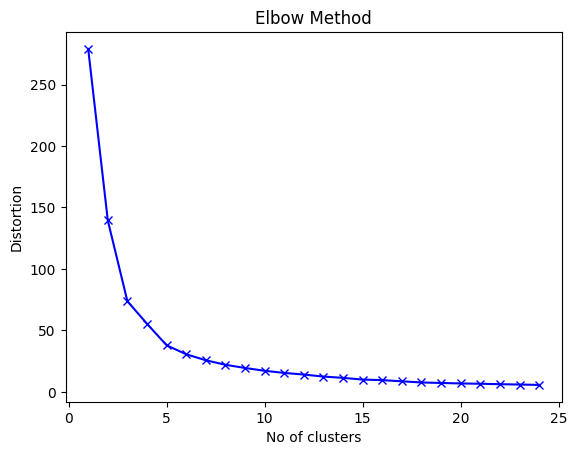

In [128]:
# Estimate K value
Humberside = data[data.police_force == 16]
k_val = K_value_estimator(Humberside[['longitude', 'latitude']])
k_val.k_estimator()

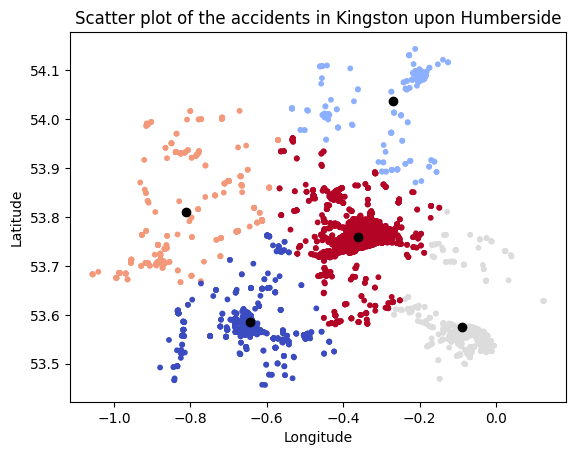

In [129]:
# Using Kmeans clustering

Humberside = data[data.police_force == 16]
kmeans = KMeans(n_clusters=5)
kmeans.fit(Humberside[['longitude', 'latitude']])

labels = kmeans.predict(Humberside[['longitude', 'latitude']])
centroids = kmeans.cluster_centers_

# Callback the class instance
humberside = Kmeans_estimator(Humberside[['longitude', 'latitude']],'Scatter plot of the accidents in Kingston upon Humberside',Humberside['longitude'], Humberside['latitude'])
humberside.kmeans_clustering()

#### Using folium library

In [130]:
#Kmeans cluster
Humberside = data[data.police_force == 16]
kmeans = KMeans(n_clusters=5)
kmeans.fit(Humberside[['longitude', 'latitude']])
Humberside['label'] = kmeans.fit_predict(Humberside[['longitude', 'latitude']])

#Obtain mean of latitude and longitude
lat_mean = np.mean(Humberside['latitude'])
long_mean = np.mean(Humberside['longitude'])

# Center of the map
center = [lat_mean, long_mean]

#Fit in the map and cluster marker
Humberside_map = folium.Map(location=center, zoom_start=10)
marker = folium.plugins.MarkerCluster().add_to(Humberside_map)

#Iterate thru the dataframe
for i, j in Humberside.iterrows():
    folium.Marker([j['latitude'], j['longitude']], popup=f"{j['label']}").add_to(marker)

Humberside_map.save('Humberside_map.html')
Humberside_map

#### c. East Riding of Yorkshire

In [131]:
# East Riding of Yorkshire = E06000011 in the local_authority_ons_district, hence, filtering becomes

Yorkshire = data[data.local_authority_ons_district == 'E06000011']

In [132]:
# Time of the day with most accidents

Yorkshire.decimal_time.value_counts()

11.500000    26
17.500000    22
12.500000    20
17.533333    18
18.500000    18
             ..
2.050000      1
22.000000     1
12.200000     1
11.916667     1
6.083333      1
Name: decimal_time, Length: 326, dtype: int64

In [133]:
# Day of week with most accidents

Yorkshire.day_of_week.value_counts()

7    194
6    183
1    179
3    171
2    168
4    157
5    149
Name: day_of_week, dtype: int64

An average of 171.57 take place every day in Yorkshire


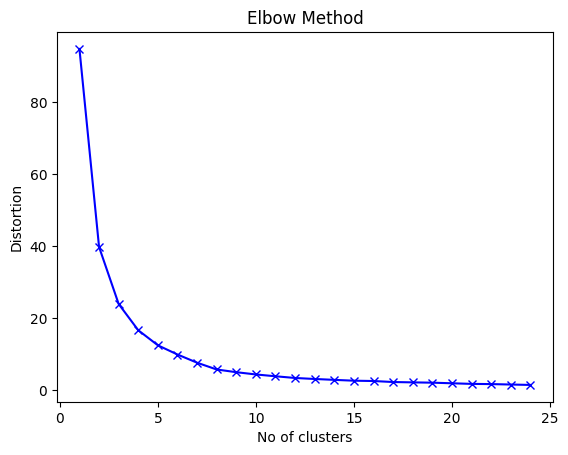

In [134]:
# Avg no of accidents
avg_york = (len(Yorkshire))/7
print(f'An average of {avg_york:.2f} take place every day in Yorkshire')

# Estimate K value
Yorkshire = data[data.local_authority_ons_district == 'E06000011']

k_val = K_value_estimator(Yorkshire[['longitude', 'latitude']])
k_val.k_estimator()

In [135]:
# No of fatal accidents

Yorkshire[data.accident_severity == 1].accident_severity.count()

25

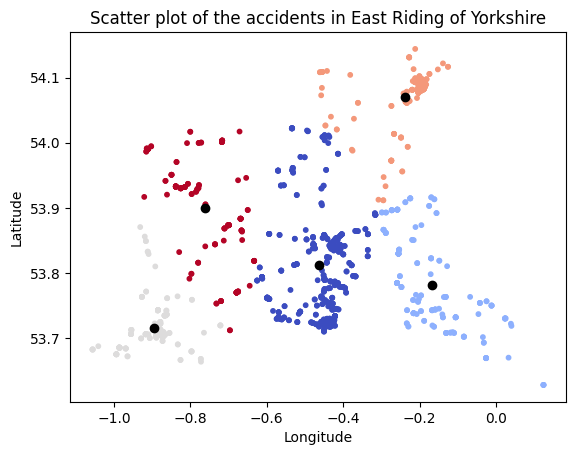

In [136]:
# Using Kmeans clustering
Yorkshire = data[data.local_authority_ons_district == 'E06000011']
kmeans = KMeans(n_clusters=5)
kmeans.fit(Yorkshire[['longitude', 'latitude']])

labels = kmeans.predict(Yorkshire[['longitude', 'latitude']])
centroids = kmeans.cluster_centers_

# Callback the class
Yorkshire = Kmeans_estimator(Yorkshire[['longitude', 'latitude']],'Scatter plot of the accidents in East Riding of Yorkshire',Yorkshire['longitude'], Yorkshire['latitude'])
Yorkshire.kmeans_clustering()

#### Using folium library

In [137]:
#Kmeans cluster
Yorkshire = data[data.local_authority_ons_district == 'E06000011']
kmeans = KMeans(n_clusters=5)
kmeans.fit(Yorkshire[['longitude', 'latitude']])
Yorkshire['label'] = kmeans.fit_predict(Yorkshire[['longitude', 'latitude']])

#Obtain mean of latitude and longitude
lat_mean = np.mean(Yorkshire['latitude'])
long_mean = np.mean(Yorkshire['longitude'])

# Center of the map
center = [lat_mean, long_mean]

#Fit in the map and cluster marker
Yorkshire_map = folium.Map(location=center, zoom_start=10)
marker = folium.plugins.MarkerCluster().add_to(Yorkshire_map)

#Iterate thru the dataframe
for i, j in Yorkshire.iterrows():
    folium.Marker([j['latitude'], j['longitude']], popup=f"{j['label']}").add_to(marker)

Yorkshire_map.save('Yorkshire_map.html')
Yorkshire_map

### Using outlier detection methods, identify unusual entries in your data set. Should you keep these entries in your data?

### Method 1: Drop the outliers

In [138]:
new = data.select_dtypes('int', 'float')

# Using isolation forest

ranst = np.random.RandomState(0)

model = IsolationForest(max_samples=100, random_state=ranst, contamination=0.01)
model.fit(new)
if_scores = model.decision_function(new)
if_anomalies = model.predict(new)

# Replace 1 as anomalies and 0 as non-anomalies
if_anomalies = pd.Series(if_anomalies).replace([-1,1], [1,0])

# Extract the anomalies
if_anomalies = new[if_anomalies==1];

#### Further visualize some columns using boxplot to find unusual entries

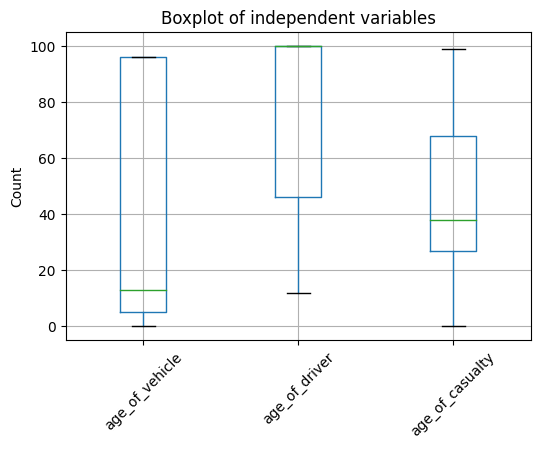

In [139]:
plt.figure(figsize=(6,4))
if_anomalies.boxplot(column=['age_of_vehicle', 'age_of_driver', 'age_of_casualty'])
plt.xticks(rotation=45)
plt.title('Boxplot of independent variables')
plt.ylabel('Count')
plt.show()

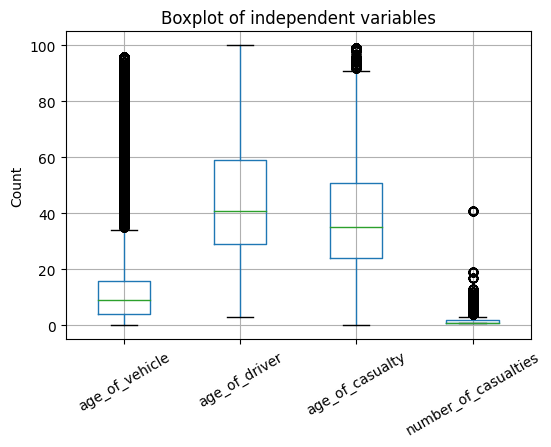

In [140]:
plt.figure(figsize=(6,4))
data.boxplot(column=['age_of_vehicle', 'age_of_driver', 'age_of_casualty', 'number_of_casualties'])
plt.xticks(rotation=30)
plt.title('Boxplot of independent variables')
plt.ylabel('Count')
plt.show()

In [141]:
# Further inspect age_of_driver
len(data[data['age_of_driver'] >= 90])

27741

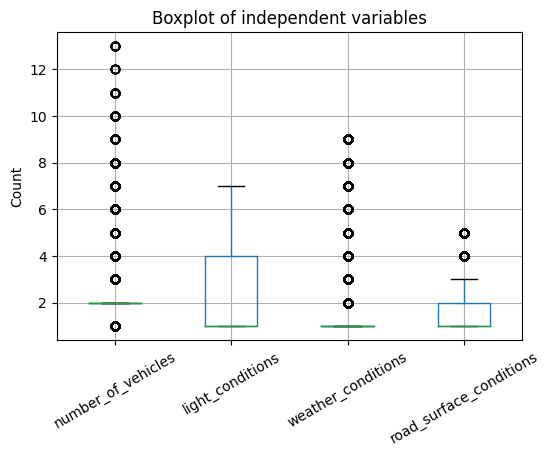

In [142]:
plt.figure(figsize=(6,4))
data.boxplot(column=['number_of_vehicles',  'light_conditions','weather_conditions', 'road_surface_conditions'])
plt.xticks(rotation=30)
plt.title('Boxplot of independent variables')
plt.ylabel('Count')
plt.show()

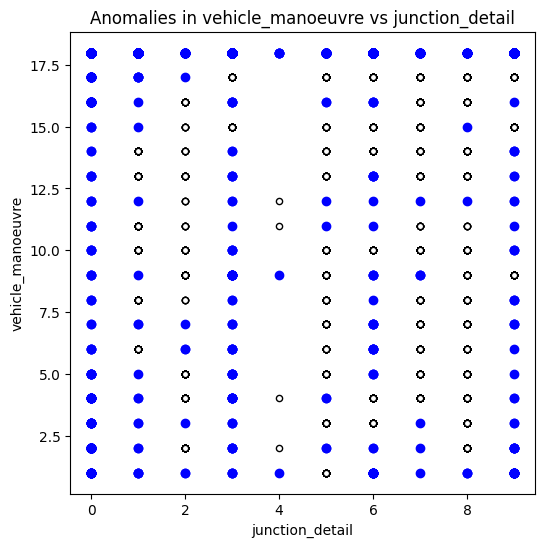

In [143]:
### Further plots for some variables with anomalies

plt.figure(figsize=(6,6))
plt.scatter(new['junction_detail'], new['vehicle_manoeuvre'], c='white', s=20, edgecolor='k')
plt.scatter(if_anomalies['junction_detail'], if_anomalies['vehicle_manoeuvre'], c='blue')
plt.title('Anomalies in vehicle_manoeuvre vs junction_detail')
plt.ylabel('vehicle_manoeuvre')
plt.xlabel('junction_detail')
plt.show();

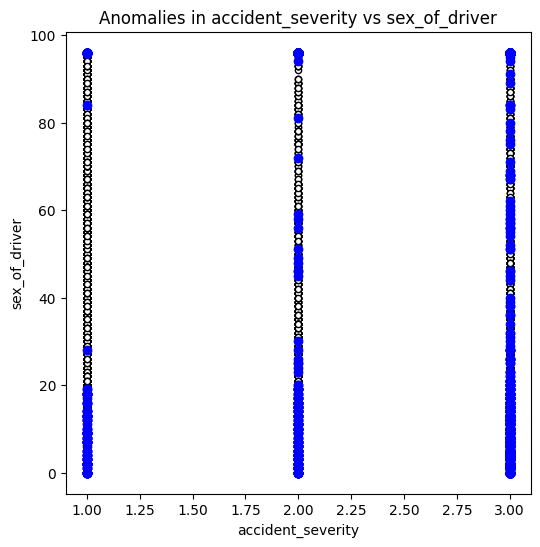

In [144]:
plt.figure(figsize=(6,6))
plt.scatter(new['sex_of_driver'], new['age_of_vehicle'], c='white', s=20, edgecolor='k')
plt.scatter(if_anomalies[ 'accident_severity'], if_anomalies['age_of_vehicle'], c='blue')
plt.title('Anomalies in accident_severity vs sex_of_driver')
plt.ylabel('sex_of_driver')
plt.xlabel('accident_severity')
plt.show();

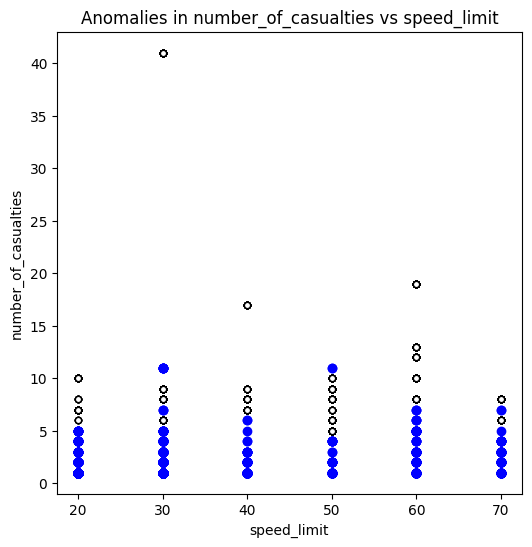

In [145]:
### Further plots for some variables with anomalies

plt.figure(figsize=(6,6))
plt.scatter(new['speed_limit'], new['number_of_casualties'], c='white', s=20, edgecolor='k')
plt.scatter(if_anomalies['speed_limit'], if_anomalies['number_of_casualties'], c='blue')
plt.title('Anomalies in number_of_casualties vs speed_limit')
plt.ylabel('number_of_casualties')
plt.xlabel('speed_limit')
plt.show();

**Two methods will be carried out to determine whether to keep or completely remove the anomalies(i.e Outliers)**

### Gain further insights from some variables

In [146]:
# Number of casualties on Fridays

data.query('accident_severity == 1 and day_of_week == 6')['number_of_casualties'].value_counts()

1    232
2    120
3    117
4    108
5      5
Name: number_of_casualties, dtype: int64

In [147]:
# Number of casualties on Saturdays

data.query('accident_severity == 1 and day_of_week == 7')['number_of_casualties'].value_counts()

1    231
3    201
2    114
5     75
4     52
6     42
Name: number_of_casualties, dtype: int64

In [148]:
# Day of the week with most fatal accidents

data.query('accident_severity == 1')['day_of_week'].value_counts()

7    715
5    713
4    616
1    602
6    582
3    519
2    484
Name: day_of_week, dtype: int64

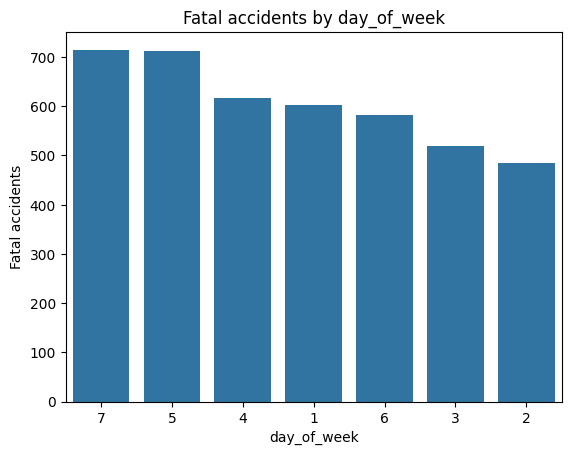

In [149]:
# Create a class to plot each relationship

class fatal_relational_plot:
    def __init__(self, order, p, t):
        self.order = order
        self.p = p
        self.t = t
        
    def countplot(self):
        # Color of plot
        color=sns.color_palette()[0]

        # Plot using Countplot
        sex_of_driver = sns.countplot(data=data.query('accident_severity == 1'), x=self.p, order=self.order, color=color)
        plt.title(self.t)
        plt.ylabel('Fatal accidents');
plot = fatal_relational_plot(data.query('accident_severity == 1')['day_of_week'].value_counts().index, 'day_of_week', 'Fatal accidents by day_of_week')
plot.countplot()

#### Sex of driver

In [150]:
# Extract fatal accidents based on sex_of_driver

data.query('accident_severity == 1')['sex_of_driver'].value_counts()

1    3306
2     788
3     137
Name: sex_of_driver, dtype: int64

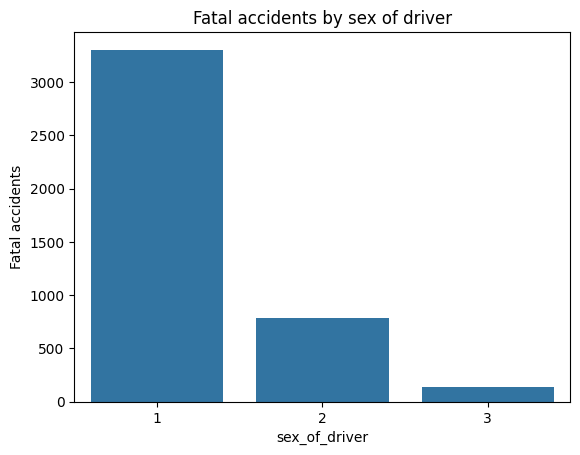

In [151]:
# Plot of fatal accidents by sex of driver
plot = fatal_relational_plot(data.query('accident_severity == 1')['sex_of_driver'].value_counts()[0:5].index, 'sex_of_driver', 'Fatal accidents by sex of driver')
plot.countplot()

#### First point of impact

In [152]:
# Extract fatal accidents based on first_point_of_impact

data.query('accident_severity == 1')['first_point_of_impact'].value_counts()

1    2584
3     581
2     443
4     332
0     291
Name: first_point_of_impact, dtype: int64

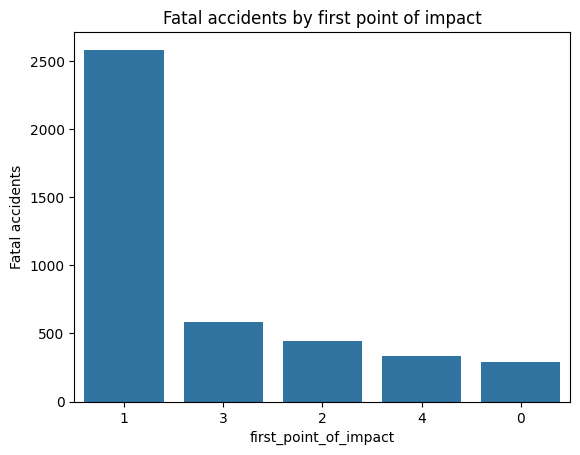

In [153]:
#Plotting first point of impact
plot = fatal_relational_plot(data.query('accident_severity == 1')['first_point_of_impact'].value_counts().index, 
                             'first_point_of_impact', 'Fatal accidents by first point of impact')
plot.countplot()

#### Lighting Condition

In [154]:
# Extract fatal accidents based on lighting condition

light = data.query('accident_severity == 1')['light_conditions'].value_counts()
light

1    2628
6     814
4     714
7      38
5      37
Name: light_conditions, dtype: int64

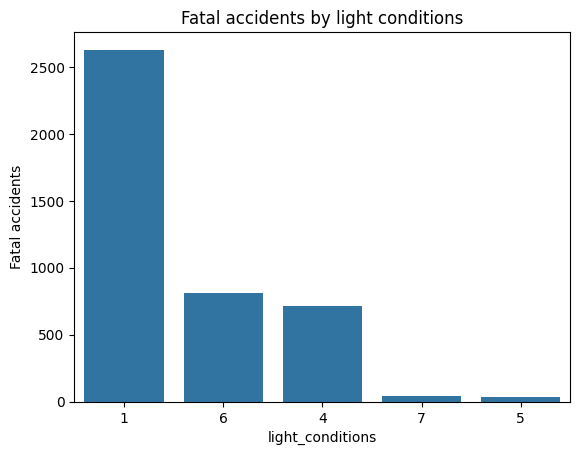

In [155]:
#Plotting light conditions
plot = fatal_relational_plot(data.query('accident_severity == 1')['light_conditions'].value_counts().index, 
                             'light_conditions', 'Fatal accidents by light conditions')
plot.countplot()

In [156]:
# Extract fatal accidents based on weather condition

weather = data.query('accident_severity == 1')['weather_conditions'].value_counts()
weather

1    3360
2     433
8     153
4     107
5      90
7      51
9      25
3      11
6       1
Name: weather_conditions, dtype: int64

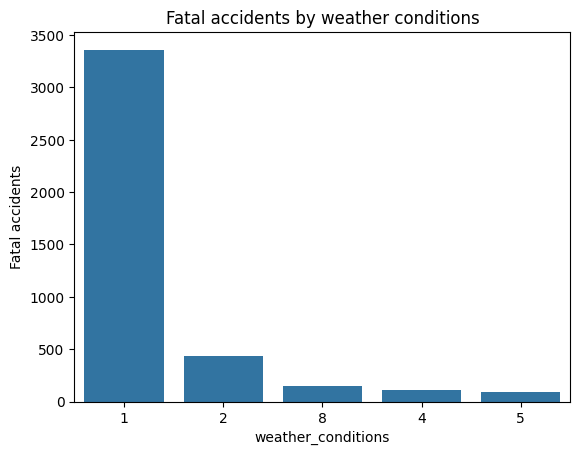

In [157]:
#Plotting weather conditions

plot = fatal_relational_plot(data.query('accident_severity == 1')['weather_conditions'].value_counts()[0:5].index, 
                             'weather_conditions', 'Fatal accidents by weather conditions')
plot.countplot()

#### Age of driver

In [158]:
# Extract fatal accidents based on age of driver

age = data.query('accident_severity == 1')['age_of_driver'].value_counts()[0:10]
age

100    160
30     117
31     111
32     109
27     106
28     103
25      99
52      97
47      97
22      96
Name: age_of_driver, dtype: int64

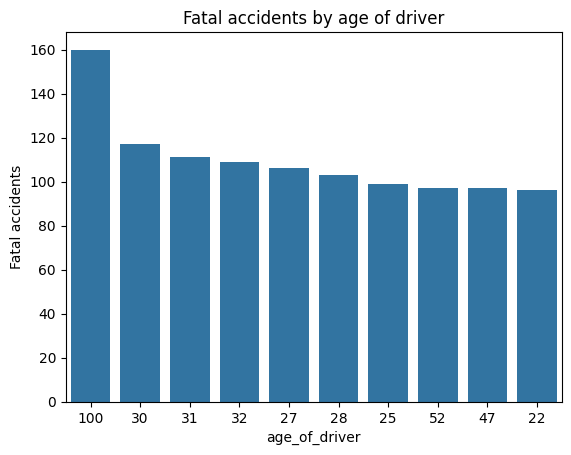

In [159]:
#Plotting age of driver
plot = fatal_relational_plot(data.query('accident_severity == 1')['age_of_driver'].value_counts()[0:10].index, 
                             'age_of_driver', 'Fatal accidents by age of driver')
plot.countplot()

In [160]:
data.query('accident_severity == 1 and age_of_driver == 100')['speed_limit'].value_counts()

30    100
40     23
70     11
60     11
50     10
20      5
Name: speed_limit, dtype: int64

In [161]:
data.query('accident_severity == 1 and age_of_driver == 100')['sex_of_driver'].value_counts()

3    120
1     35
2      5
Name: sex_of_driver, dtype: int64

In [162]:
data.query('accident_severity == 1 and age_of_driver == 100')['vehicle_type'].value_counts()

9     126
19     14
21      9
98      5
11      3
5       2
90      1
Name: vehicle_type, dtype: int64

#### Urban or rural area

In [163]:
# Extract fatal accidents based on urban or rural area

urban = data.query('accident_severity == 1')['urban_or_rural_area'].value_counts()
urban

2    2867
1    1364
Name: urban_or_rural_area, dtype: int64

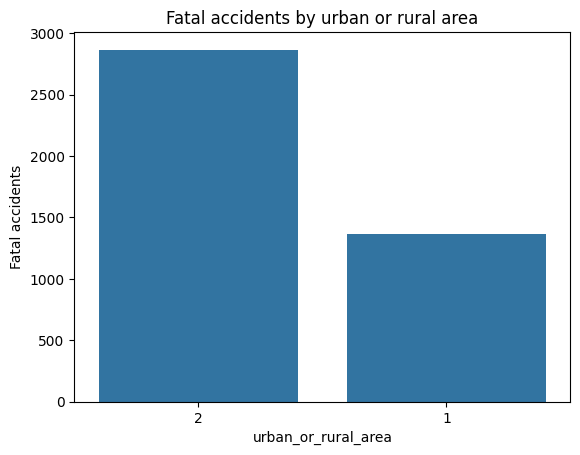

In [164]:
#Plotting urban or rural area
plot = fatal_relational_plot(data.query('accident_severity == 1')['urban_or_rural_area'].value_counts().index, 
                             'urban_or_rural_area', 'Fatal accidents by urban or rural area')
plot.countplot()

#### Vehicle manoeuvre

In [165]:
# Extract fatal accidents based on vehicle manoeuvre

data.query('accident_severity == 1')['vehicle_manoeuvre'].value_counts()[0:10]

18    2629
16     351
17     336
2      216
9      201
13     124
4       86
3       73
5       44
7       38
Name: vehicle_manoeuvre, dtype: int64

In [166]:
data.query('accident_severity == 1 and vehicle_manoeuvre == 18')['urban_or_rural_area'].value_counts()

2    1746
1     883
Name: urban_or_rural_area, dtype: int64

In [167]:
data.query('accident_severity == 1 and vehicle_manoeuvre == 18')['vehicle_type'].value_counts() # Car and Van/Goods vehicle 3.5 tonnes maximum gross weight (mgw) and under

9     1770
19     180
21     157
5      138
1      136
3       65
8       35
4       34
20      26
11      17
17      14
97      14
98      14
90      13
10      11
22       2
2        2
16       1
Name: vehicle_type, dtype: int64

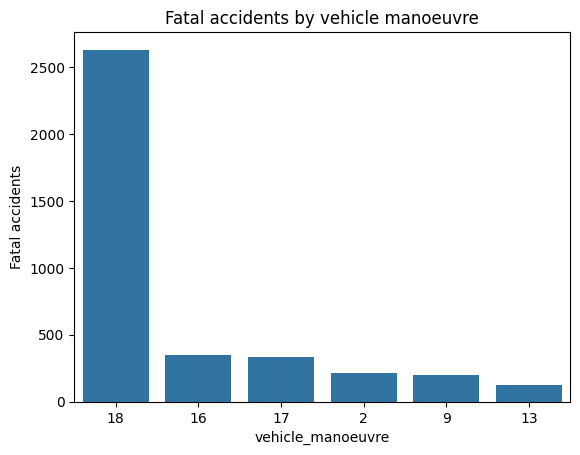

In [168]:
#Plotting vehicle manoeuvre

plot = fatal_relational_plot(data.query('accident_severity == 1')['vehicle_manoeuvre'].value_counts()[0:6].index, 
                             'vehicle_manoeuvre', 'Fatal accidents by vehicle manoeuvre')
plot.countplot()

#### first road class

In [169]:
# Extract fatal accidents based on first road class

data.query('accident_severity == 1')['first_road_class'].value_counts()

3    2102
1     937
6     531
4     489
5     168
2       4
Name: first_road_class, dtype: int64

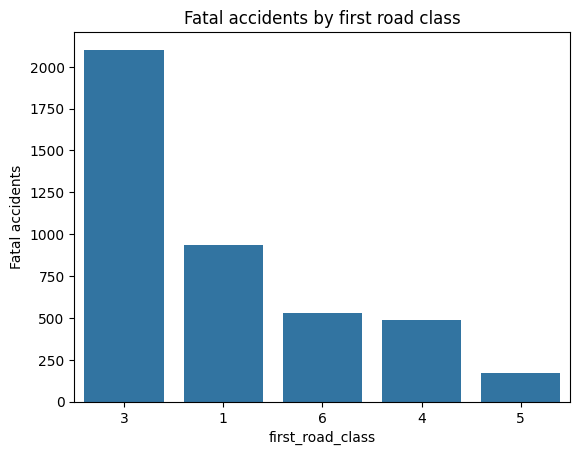

In [170]:
#Plotting first road class

plot = fatal_relational_plot(data.query('accident_severity == 1')['first_road_class'].value_counts()[0:5].index, 
                             'first_road_class', 'Fatal accidents by first road class')
plot.countplot()

#### Junction detail

In [171]:
# Extract fatal accidents based on junction detail

data.query('accident_severity == 1')['junction_detail'].value_counts()

0    2869
3     784
6     189
9     113
5     110
1      84
8      67
7       8
2       7
Name: junction_detail, dtype: int64

In [172]:
data.query('accident_severity == 1 and junction_detail == 0 and first_road_class == 3')['urban_or_rural_area'].value_counts()

2    1219
1     178
Name: urban_or_rural_area, dtype: int64

In [173]:
data.query('accident_severity == 1 and junction_detail == 0 and first_road_class == 3 and \
           urban_or_rural_area == 2')['road_surface_conditions'].value_counts()

1    749
2    460
4      5
5      4
3      1
Name: road_surface_conditions, dtype: int64

In [174]:
off_carriage = data.query('accident_severity == 1 and junction_detail == 0 and first_road_class == 3 and \
           urban_or_rural_area == 2')['hit_object_off_carriageway'].value_counts()[0]
total_off = data.query('accident_severity == 1 and junction_detail == 0 and first_road_class == 3 and \
           urban_or_rural_area == 2')['hit_object_off_carriageway'].count()
print(f'{off_carriage} of {total_off} accounted for A-class roads not within 20 metres of a junction in rural areas with no signal')

1032 of 1219 accounted for A-class roads not within 20 metres of a junction in rural areas with no signal


In [175]:
data.query('accident_severity == 1 and junction_detail == 0 and first_road_class == 3 and \
           urban_or_rural_area == 2')['vehicle_type'].value_counts()

9     812
21    106
5      77
19     76
1      43
20     21
17     14
3      13
98     13
8      12
10     12
11      9
4       5
90      4
97      1
2       1
Name: vehicle_type, dtype: int64

In [176]:
data.query('accident_severity == 1 and junction_detail == 0 and first_road_class == 3 and \
           urban_or_rural_area == 2')['vehicle_manoeuvre'].value_counts()

18    660
16    194
17    140
13     87
2      45
4      29
9      16
3       8
15      7
6       7
7       6
11      5
1       4
14      4
5       4
12      3
Name: vehicle_manoeuvre, dtype: int64

In [177]:
data.query('accident_severity == 1 and junction_detail == 0 and first_road_class == 3 and \
           urban_or_rural_area == 2')['journey_purpose_of_driver'].value_counts()

6    635
1    262
5    224
2     88
3     10
Name: journey_purpose_of_driver, dtype: int64

In [178]:
data.query('accident_severity == 1 and junction_detail == 0')['first_road_class'].value_counts()

3    1397
1     871
4     264
6     220
5     117
Name: first_road_class, dtype: int64

In [179]:
no_junction = data.query('accident_severity == 1')['junction_detail'].value_counts()[0]
total_accidents = len(data.query('accident_severity == 1')['junction_detail'])
percent_no_junction = (no_junction/total_accidents)*100
print(f'{percent_no_junction:.2f}% of fatal accidents took place 20 metres away from a junction')

67.81% of fatal accidents took place 20 metres away from a junction


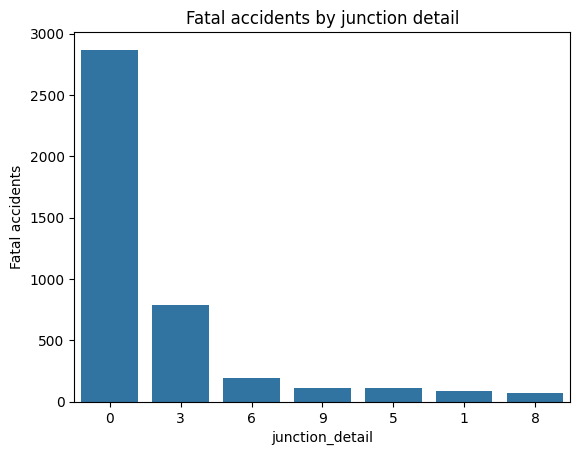

In [180]:
#Plotting junction detail
plot = fatal_relational_plot(data.query('accident_severity == 1')['junction_detail'].value_counts()[0:7].index, 
                             'junction_detail', 'Fatal accidents by junction detail')
plot.countplot()

#### Speed limit

In [181]:
# Extract fatal accidents based on speed limit

data.query('accident_severity == 1')['speed_limit'].value_counts()

60    1635
30    1169
70     560
40     447
50     326
20      94
Name: speed_limit, dtype: int64

In [182]:
data.query('accident_severity != 0')['speed_limit'].describe()

count    220435.000000
mean         37.868941
std          14.615621
min          20.000000
25%          30.000000
50%          30.000000
75%          50.000000
max          70.000000
Name: speed_limit, dtype: float64

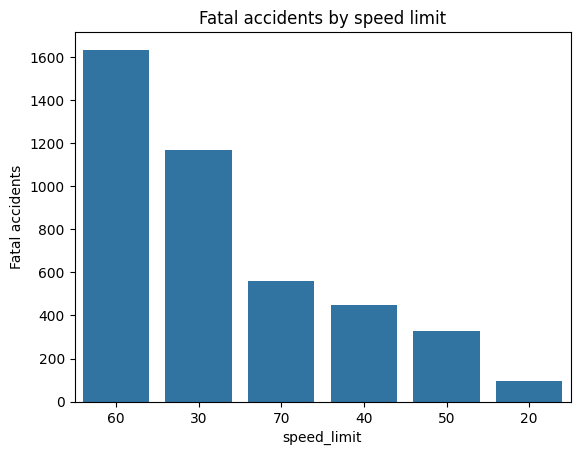

In [183]:
#Plotting speed limit
plot = fatal_relational_plot(data.query('accident_severity == 1')['speed_limit'].value_counts().index, 
                             'speed_limit', 'Fatal accidents by speed limit')
plot.countplot()

#### Number of Casualties

In [184]:
# Extract fatal accidents based on number of casualties

data.query('accident_severity == 1')['number_of_casualties'].value_counts()

1     1511
2      888
3      837
4      448
5      235
6      138
11      88
8       48
19      38
Name: number_of_casualties, dtype: int64

In [185]:
data.query('accident_severity == 1 and number_of_casualties == 19')['number_of_vehicles'].value_counts()

2    38
Name: number_of_vehicles, dtype: int64

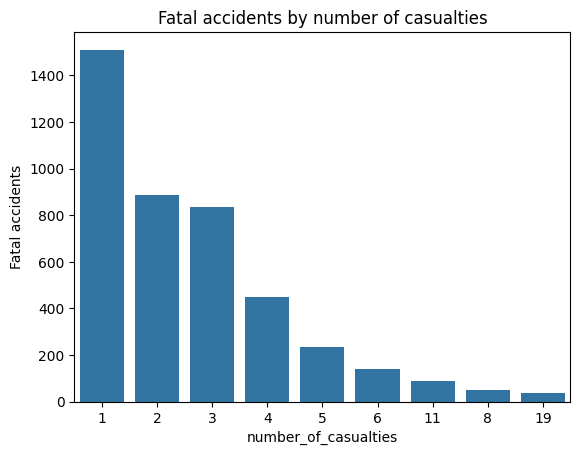

In [186]:
#Plotting number of casualties
plot = fatal_relational_plot(data.query('accident_severity == 1')['number_of_casualties'].value_counts().index, 
                             'number_of_casualties', 'Fatal accidents by number of casualties')
plot.countplot()

#### Number of vehicles

In [187]:
# Extract fatal accidents based on number of vehicles

data.query('accident_severity == 1')['number_of_vehicles'].value_counts()

2    1754
3     894
1     851
4     376
8     160
6      90
5      85
7      21
Name: number_of_vehicles, dtype: int64

In [188]:
data.query('accident_severity == 1')['number_of_vehicles'].count()

4231

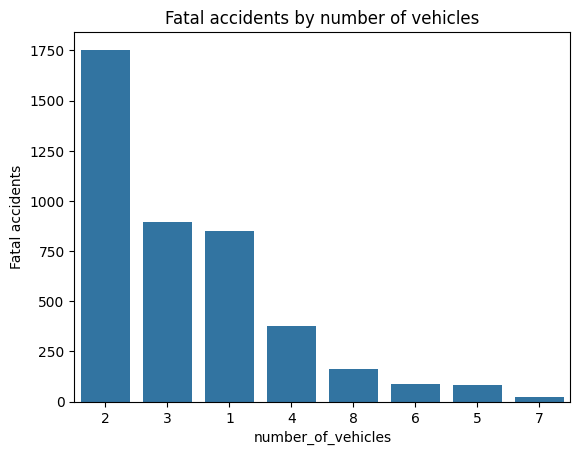

In [189]:
#Plotting number of vehicles
plot = fatal_relational_plot(data.query('accident_severity == 1')['number_of_vehicles'].value_counts().index, 
                             'number_of_vehicles', 'Fatal accidents by number of vehicles')
plot.countplot()

#plot multiple figures with Pairgrid
g = sns.PairGrid(data = data,  y_vars = ['age_of_driver','age_of_casualty', 'age_of_vehicle'],x_vars = ['accident_severity'])
g.map(sns.boxplot, color = color);
plt.show();

#### Police Force

In [190]:
# Extract fatal accidents based on police force

police_force = data.query('accident_severity == 1')['police_force'].value_counts().sort_values(ascending=False).nlargest(10)
police_force

1     268
32    233
43    207
6     192
47    169
46    157
50    150
44    128
97    121
36    119
Name: police_force, dtype: int64

In [191]:
data.query('accident_severity == 1 and police_force == 1')['number_of_vehicles'].value_counts()

8    88
2    78
1    66
3    36
Name: number_of_vehicles, dtype: int64

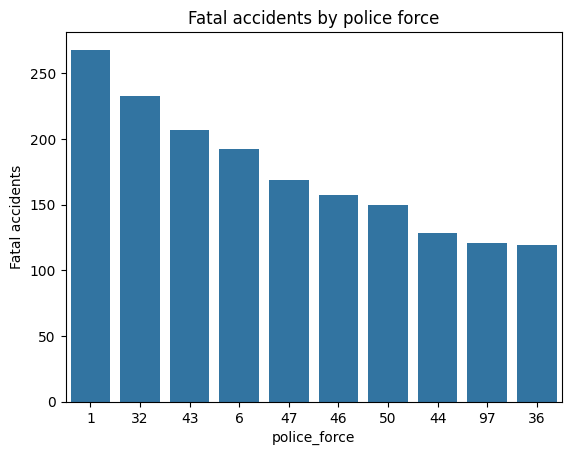

In [192]:
#Plotting police force
plot = fatal_relational_plot(data.query('accident_severity == 1')['police_force'].value_counts()[0:10].index, 
                             'police_force', 'Fatal accidents by police force')
plot.countplot()

###### Regions with the most fatal accidents

1 = Metropolitan Police, 32 = Lincolnshire, 43 = Thames Valley, 6 = Greater Manchester, 47 = Sussex, 46 = Kent, 50 = Devon and Cornwall,
44 = Hampshire, 97 = Strathclyde, 36 = Norfolk

#### Pedestrian crossing physical facilities

In [193]:
data.query('accident_severity == 1')['pedestrian_crossing_physical_facilities'].value_counts()

0    3815
4     144
5     125
8      95
1      31
7      21
Name: pedestrian_crossing_physical_facilities, dtype: int64

In [194]:
ped = data.query('accident_severity == 1')['pedestrian_crossing_physical_facilities'].value_counts()[0]
ped_percent = (ped/total_accidents)*100
print(f'In UK, {ped} of {total_accidents} accounted for {ped_percent:.2f}% of total fatal accidents in 2020')

In UK, 3815 of 4231 accounted for 90.17% of total fatal accidents in 2020


In [195]:
# Investigate further
data.query('accident_severity == 1 and pedestrian_crossing_physical_facilities == 0')['local_authority_ons_district'].value_counts()

E06000052    101
E09000016     96
E07000137     69
E06000047     63
E06000049     52
            ... 
E06000005      1
E07000048      1
E07000047      1
E07000032      1
S12000013      1
Name: local_authority_ons_district, Length: 328, dtype: int64

In [196]:
data.query('accident_severity == 1')['local_authority_ons_district'].value_counts()

E06000052    101
E09000016     96
E06000047     73
E07000137     71
E06000049     52
            ... 
E06000005      1
E07000138      1
E06000033      1
E09000014      1
S12000013      1
Name: local_authority_ons_district, Length: 345, dtype: int64

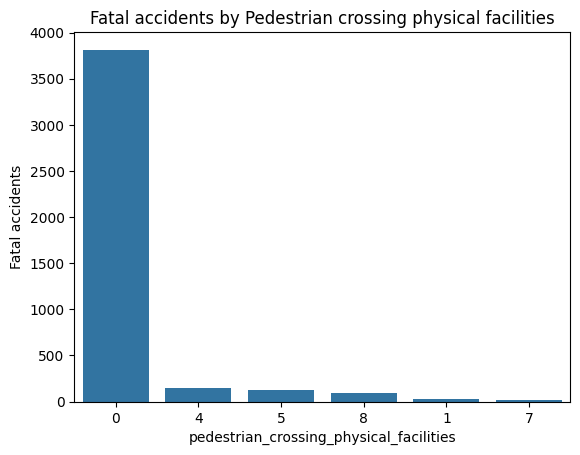

In [197]:
#Plotting 'pedestrian_crossing_physical_facilities'
plot = fatal_relational_plot(data.query('accident_severity == 1')['pedestrian_crossing_physical_facilities'].value_counts()[0:10].index, 
                             'pedestrian_crossing_physical_facilities', 'Fatal accidents by Pedestrian crossing physical facilities')
plot.countplot()

#### Type of vehicle

In [198]:
data.query('accident_severity == 1')['vehicle_type'].value_counts().sort_values(ascending=False).nlargest(10)

9     2802
19     301
21     281
5      269
1      167
3       78
11      63
8       52
20      52
4       49
Name: vehicle_type, dtype: int64

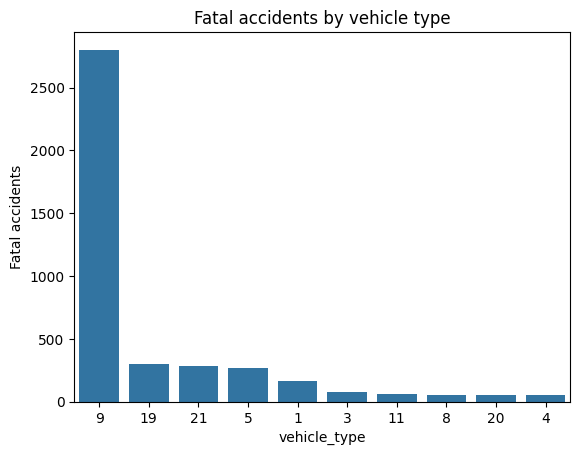

In [199]:
#Plotting vehicle type
plot = fatal_relational_plot(data.query('accident_severity == 1')['vehicle_type'].value_counts()[0:10].index, 
                             'vehicle_type', 'Fatal accidents by vehicle type')
plot.countplot()

#### Road surface condition

In [200]:
# Extract fatal accidents based on road cond

road_cond = data.query('accident_severity == 1')['road_surface_conditions'].value_counts().sort_values(ascending=False).nlargest(10)
road_cond

1    2659
2    1531
4      25
5      14
3       2
Name: road_surface_conditions, dtype: int64

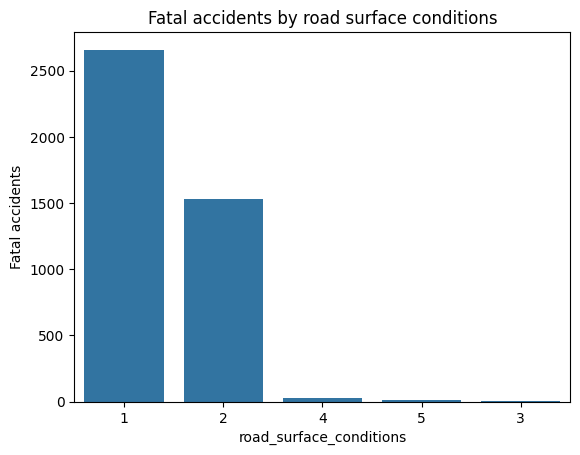

In [201]:

plot = fatal_relational_plot(data.query('accident_severity == 1')['road_surface_conditions'].value_counts().index, 
                             'road_surface_conditions', 'Fatal accidents by road surface conditions')
plot.countplot()

### Can you develop a classification model using the provided data that accurately predicts fatal injuries sustained in road traffic accidents, with the aim of informing and improving road safety measures?

In [202]:
# Representing: 1 - Fatal, 0 - Non-fatal
#Hence, convert 2,3 in the accident_severity column to 0

data['accident_severity'].replace([2,3], 0, inplace=True)

# Imbalance class
print(data['accident_severity'].value_counts())

# Represent this as y_label
y_label = data['accident_severity']

0    216204
1      4231
Name: accident_severity, dtype: int64


In [203]:
# Drop accident severity column

df_acct = data.drop(columns=['accident_severity'])

# Applying RandomUnderSampler

X_res, y_res = RandomUnderSampler().fit_resample(df_acct, y_label)

y_res.value_counts()

0    4231
1    4231
Name: accident_severity, dtype: int64

In [204]:
# Police officers are more likely to attend an accident if it is fatal, and we are interested in the causes of fatal accidents not how the police respond after the event.
# casualty_severity is almost same as accident_severity hence, to avoid multicolinearity, we remove it
# Local authority district is removed since police force also shows location
# casualty home details are not relevant at this instance

X_res.drop(columns=['did_police_officer_attend_scene_of_accident', 'casualty_severity', 'casualty_home_area_type','local_authority_district'], inplace=True)

# Extract numerical columns
X_res = X_res.select_dtypes(['int', 'float'])

### Data Preprocessing

#### Feature Selection

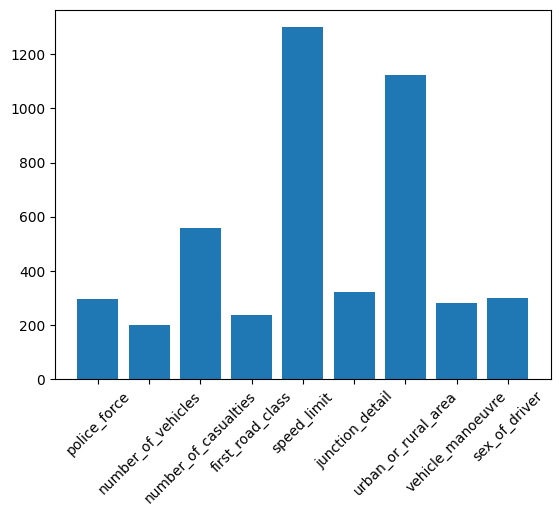

In [190]:
# Create the feature selector
selector = SelectKBest(f_classif, k=9)
selector.fit(X_res, y_res)

mask = selector.get_support()
names = selector.feature_names_in_[mask]
scores = selector.scores_[mask]

# Print result using barplot

plt.bar(names, scores)
plt.xticks(rotation=45);

In [191]:
# Select the columns needed

X = X_res[['speed_limit', 'police_force', 'number_of_vehicles', 'number_of_casualties', 'junction_detail', 'first_road_class','vehicle_manoeuvre', 'urban_or_rural_area', 'sex_of_driver']]

### Method 1: Keep the outliers

#### Normalize the dataset

In [192]:
#normalizing the dataset

nom = MinMaxScaler()
nom.fit(X)
X_res = nom.transform(X)

#### Model Performance

In [193]:
#A function to classify the dataset by building and evaluating the model
def model_evaluator(X, y, scoring):
    classifiers = []
    #Classifiers to be used
    classifiers.append(('LR', LogisticRegression()))
    classifiers.append(('GBC', GradientBoostingClassifier(n_estimators=100, random_state=42)))
    classifiers.append(('RFC', RandomForestClassifier(n_estimators=100, random_state=42)))
    classifiers.append(('DTC', DecisionTreeClassifier()))

    #Create an empty dictionary
    result = dict()

    #Iterate thru the list of classifiers using cross validation
    for name, classifier in classifiers:
        cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
        scores = cross_val_score(classifier, X, y, scoring=scoring, cv=cv, error_score='raise')
        result[name]=(round(scores.mean(),2), round(scores.std(),2))
    
    return result

In [194]:
# Call the function

accuracy = model_evaluator(X_res, y_res, scoring='accuracy')

f1 = model_evaluator(X_res, y_res, scoring='f1_macro')

print(f'accuracy:{accuracy} and f1:{f1}')

accuracy:{'LR': (0.72, 0.01), 'GBC': (0.76, 0.01), 'RFC': (0.82, 0.01), 'DTC': (0.79, 0.01)} and f1:{'LR': (0.72, 0.01), 'GBC': (0.76, 0.01), 'RFC': (0.82, 0.01), 'DTC': (0.79, 0.01)}


### Build Model using Cross Validation

In [195]:
clf_1 = GradientBoostingClassifier(n_estimators=100, random_state=42)
clf_2 = RandomForestClassifier(n_estimators=100, random_state=42)
clf_3 = DecisionTreeClassifier()
    
base = LogisticRegression()
    
stacked = StackingClassifier(classifiers=[clf_1, clf_2, clf_3], meta_classifier=base)

In [196]:
for classifier, label in zip([clf_1, clf_2, clf_3, stacked], ['GBC', 'RFC', 'DTC', 'Stacking']):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    scores = cross_val_score(classifier, X_res, y_res, scoring='accuracy',cv=cv, error_score='raise')
    print(round(scores.mean(),2), round(scores.std(),2), label)

0.76 0.01 GBC
0.82 0.01 RFC
0.79 0.01 DTC
0.79 0.01 Stacking


Bhatt, B. (2019). Stacking Classifier | Ensemble Classifiers | Machine Learning. YouTube. Available at: https://www.youtube.com/watch?v=sBrQnqwMpvA [Accessed 2 Aug. 2023].

In [197]:
####### Applying RandomUnderSampler

X_res, y_res = RandomUnderSampler().fit_resample(X, y_res)

#normalizing the dataset

nom = MinMaxScaler()
nom.fit(X_res)
X_res = nom.transform(X_res)

In [198]:
## Random forest Classifier is used since it gave the best result

def train_model(X, y):
    #Cross_validation train_test strategy for classification report and confusion matrix computing
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

    #Create a list test score 
    test = []
    #Using for loop, iterate through using cross_validation split
    for train_ind, test_ind in cv.split(X_res, y_res):
        #Split X and y into train and test dataset
        #x_train, x_test, y_train, y_test = X_res[train_ind,:], X_res[test_ind,:], y_res[train_ind], y_res[test_ind]
        x_train, x_test, y_train, y_test = X_res.iloc[train_ind,:], X_res.iloc[test_ind,:], y_res.iloc[train_ind], y_res.iloc[test_ind]

        #Build the model
        #model = stacked
        model = RandomForestClassifier(n_estimators=100, random_state=42)

        #Fit the model into X and y train
        model.fit(x_train, y_train)

        #Predict the test
        y_pred = model.predict(x_test)

        #Append the accuracy into the empty list
        test.append(accuracy_score(y_test, y_pred))

        #Estimate the mean score of test accuracy
        avg_test_scores = np.mean(test)
    return avg_test_scores, y_test, y_pred

avg_test_scores, y_test, y_pred = train_model(X_res, y_res)

print(f'The average accuracy scores for the testing data is {avg_test_scores:.2f}')

The average accuracy scores for the testing data is 0.82


In [199]:
#Print the classification report
print('Classification Report:')
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.81      0.82       846
           1       0.82      0.84      0.83       846

    accuracy                           0.83      1692
   macro avg       0.83      0.83      0.83      1692
weighted avg       0.83      0.83      0.83      1692



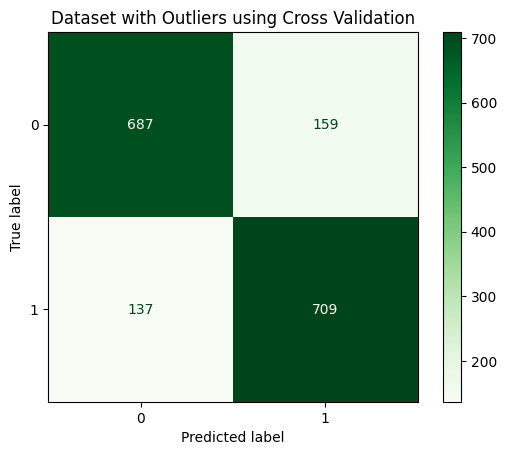

In [200]:
#Print the confusion matrix
cmd = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
cmd.plot(cmap=plt.cm.Greens)
plt.title('Dataset with Outliers using Cross Validation')
plt.show(); #Predicted 687 persons are most likely to experience a non-fatal accident

In [203]:
accidents = 1692
accurately_predicted_fatal_accidents = 709
accurately_predicted_non_fatal_accidents = 687
percent_fatal = (accurately_predicted_fatal_accidents/accidents)*100

print(f'The percentage of accurately predicting a fatal accident is {percent_fatal:.2f}%. Meaning, for every 1692 accidents, 716 is said to be fatal')

The percentage of accurately predicting a fatal accident is 41.90%. Meaning, for every 1692 accidents, 716 is said to be fatal


In [204]:
Total_fatal = (accurately_predicted_fatal_accidents/accidents) * len(data)
int(Total_fatal)

92369

### Build model using train_test split

In [205]:
####### Applying RandomUnderSampler

X_res, y_res = RandomUnderSampler().fit_resample(X, y_res)

#### Split the dataset into train, test and validation

In [206]:
# Ratio of the dataset
train_ratio = 0.5
val_ratio = 0.25
test_ratio = 0.25

# Test split
rem_x, x_test, rem_y, y_test = train_test_split(X_res, y_res, test_size=test_ratio, random_state=0)

# val ratio adjustment
rem_ratio = 1 - test_ratio
adjust_val = val_ratio/ rem_ratio

# train and val splits.
x_train, x_val, y_train, y_val = train_test_split(rem_x, rem_y, test_size=adjust_val, random_state=0)

Sklearn, in (2016). Train/Test/Validation Set Splitting in Sklearn. [online] Data Science Stack Exchange. Available at: https://datascience.stackexchange.com/questions/15135/train-test-validation-set-splitting-in-sklearn [Accessed 3 Aug. 2023].

#### Build the model

#normalizing the dataset

nom = MinMaxScaler()
nom.fit(x_train)
x_train = nom.transform(x_train)

x_test = nom.transform(x_test)
x_val = nom.transform(x_val)

In [207]:
# Classifier to be used
#classifier = stacked 
classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
classifier.fit(x_train, y_train)

# Make prediction using the validation sample
y_pred_val = classifier.predict(x_val)

# Test the model using validation samples
val_accuracy = accuracy_score(y_val, y_pred_val)
print(f'Validation_accuracy: {val_accuracy:.2f}')

Validation_accuracy: 0.78


In [208]:
# Hyperparamater tuning using GridSearch for random forest classifier with cross_validation

# The hyperparameters (n_estimators and max_depth hyperparameters)
param_grid = {'n_estimators': [100, 110, 120, 130, 140, 150], 'max_depth': [2,3,4,5,6,7]}

# Build the model
model = RandomForestClassifier(random_state=42) #The number can vary
grid = GridSearchCV(model, param_grid, cv=5, n_jobs = -1, scoring='accuracy')

# Fit the model on the training set
grid.fit(x_train, y_train)

#Ascertain the best hyperparameter
best_params = grid.best_params_

# Obtaining the best accuracy score
grid.best_score_

#Rebuilding the model with the best parameters obtained
model_gs = RandomForestClassifier(**best_params, random_state=42)
model_gs

RandomForestClassifier(max_depth=7, n_estimators=110, random_state=42)

####### Classifier to be used
classifier = RandomForestClassifier(max_depth=7, random_state=42)

####### Train the model
classifier.fit(x_train, y_train)

######## Make prediction using the validation sample
y_pred_val = classifier.predict(x_val)

####### Test the model using validation samples
val_accuracy = accuracy_score(y_val, y_pred_val)
print(f'Validation_accuracy: {val_accuracy:.2f}')

#### The accuracy further reduced after making use of the best hyperparameter obtained using gridsearchcv instead of increasing hence, we retain the previous hyperparameter

In [209]:
#### Evaluate the model using the test samples

# Make prediction using the test sample
y_pred = classifier.predict(x_test)

test_accuracy = accuracy_score(y_test, y_pred)
print(f'test_accuracy: {test_accuracy:.2f}')

test_accuracy: 0.82


In [210]:
#Print the classification report
print('Classification Report:')
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.78      0.81      1057
           1       0.80      0.85      0.82      1059

    accuracy                           0.82      2116
   macro avg       0.82      0.82      0.82      2116
weighted avg       0.82      0.82      0.82      2116



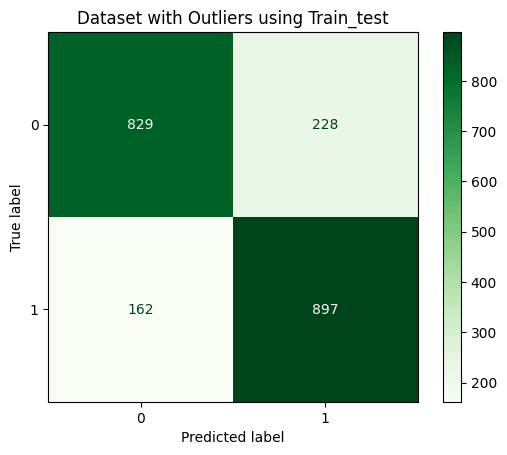

In [211]:
#Print the confusion matrix
cmd = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
cmd.plot(cmap=plt.cm.Greens)
plt.title('Dataset with Outliers using Train_test')
plt.show();

### Method 2: Remove the outliers

In [212]:
# Merge the object variables

obj = data.select_dtypes(exclude=['int', 'float'])
merge_df = pd.concat([if_anomalies, obj], axis=1)
merge_df.dropna(inplace=True)

##### Drop outliers from the original dataset

####### Some unrealistic values exist which are anomalies e.g age of vehicle as 100 years

df = pd.merge(data, merge_df, indicator = True, how = 'outer').query('_merge == "left_only"').drop('_merge', axis = 1)

In [213]:
# Convert values obtained from the KDE to int
for column in df.columns:
    if column in list_cas:
        df[column] = df[column].astype('int')

# Convert values obtained from the KDE to int
for column in df.columns:
    if column in int_list:
        df[column] = df[column].astype('int')
        
# Convert values obtained from the KDE to int
for column in df.columns:
    if column in new_list:
        df[column] = df[column].astype('int')

In [214]:
df.sample(2)

location_easting_osgr  location_northing_osgr  longitude   latitude  \
153041               483133.0                204581.0  -0.797561  51.733790   
173797               561222.0                143548.0   0.304677  51.168454   

        police_force  accident_severity  number_of_vehicles  \
153041            43                  1                   2   
173797            46                  0                   3   

        number_of_casualties  day_of_week  local_authority_district  ...  \
153041                     2            2                       480  ...   
173797                     1            4                       543  ...   

       casualty_severity pedestrian_location  pedestrian_movement  \
153041                 3                  10                    9   
173797                 2                  10                    9   

        car_passenger  bus_or_coach_passenger  \
153041              0                       0   
173797              0                       0   

        pedestrian_road_maintenance_worker  casualty_type  \
153041                                   0              9   
173797                                   0              2   

        casualty_home_area_type  casualty_imd_decile  decimal_time  
153041                        1                    9     15.933333  
173797                        1                    4     19.500000  

[2 rows x 66 columns]

In [215]:
# Representing: 1 - Fatal, 0 - Non-fatal
#Hence, convert 2,3 in the accident_severity column to 0

df['accident_severity'].replace([2,3], 0, inplace=True)

# Imbalance class

print(df['accident_severity'].value_counts())

# Represent this as y_label

y_lab = df['accident_severity']

# Drop accident severity column

df_a = df.drop(columns=['accident_severity'])


df_a.drop(columns=['did_police_officer_attend_scene_of_accident', 'casualty_severity'], inplace=True)

0    216204
1      4085
Name: accident_severity, dtype: int64


In [216]:
# Select the columns needed

X = df_a[['speed_limit', 'police_force', 'number_of_casualties', 'number_of_vehicles', 'junction_detail', 'first_road_class','vehicle_manoeuvre', 'urban_or_rural_area', 'sex_of_driver']]

# Applying RandomUnderSampler

X_res, y_res = RandomUnderSampler().fit_resample(X, y_lab)

In [217]:
print(X_res.shape)
print(y_res.shape)

(8170, 9)
(8170,)


In [218]:
# Normalize the dataset

nom = MinMaxScaler()
nom.fit(X_res)
X_res = nom.transform(X_res)

# Call the function

accuracy = model_evaluator(X_res, y_res, scoring='accuracy')

f1 = model_evaluator(X_res, y_res, scoring='f1_macro')

print(f'accuracy:{accuracy} and f1:{f1}')

accuracy:{'LR': (0.7, 0.01), 'GBC': (0.76, 0.01), 'RFC': (0.81, 0.01), 'DTC': (0.78, 0.01)} and f1:{'LR': (0.7, 0.01), 'GBC': (0.76, 0.01), 'RFC': (0.81, 0.01), 'DTC': (0.78, 0.01)}


In [219]:
for classifier, label in zip([clf_1, clf_2, clf_3, stacked], ['GBC', 'RFC', 'DTC', 'Stacking']):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(classifier, X_res, y_res, scoring='accuracy',cv=cv, error_score='raise')
    print(round(scores.mean(),2), round(scores.std(),2), label)

0.76 0.02 GBC
0.82 0.02 RFC
0.79 0.01 DTC
0.79 0.02 Stacking


#### Using Random Forest

In [221]:
# Normalisation is not required when Random Forest is used hence, we run the X and y again

# Applying RandomUnderSampler

X_res, y_res = RandomUnderSampler().fit_resample(X, y_lab)

In [223]:
avg_test_scores, y_test, y_pred = train_model(X_res, y_res)
print(f'The average accuracy scores for the testing data is {avg_test_scores:.2f}')

The average accuracy scores for the testing data is 0.81


In [224]:
#Print the classification report
print('Classification Report:')
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.79      0.80       817
           1       0.80      0.83      0.81       817

    accuracy                           0.81      1634
   macro avg       0.81      0.81      0.81      1634
weighted avg       0.81      0.81      0.81      1634



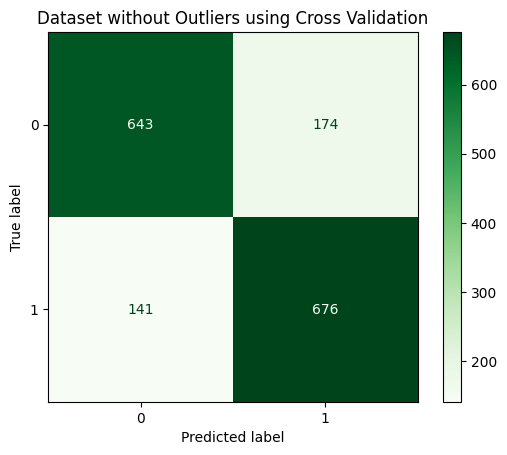

In [225]:
#Print the confusion matrix
cmd = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
cmd.plot(cmap=plt.cm.Greens)
plt.title('Dataset without Outliers using Cross Validation')
plt.show();

## Condition 2: (Effect of dropping all columns with -1 and some with 0, 9 and 99 present)

In [226]:
# Recall the copied dataset before investigation

accident_df.sample(5)

accident_index  accident_year accident_reference  location_easting_osgr  \
80600  2020522002301           2020          522002301               361737.0   
20021  2020010284992           2020          010284992               529259.0   
88796  2020990955683           2020          990955683               359759.0   
28139  2020070004386           2020          070004386               373773.0   
75557  2020470972307           2020          470972307               530557.0   

       location_northing_osgr  longitude   latitude  police_force  \
80600                171335.0  -2.551889  51.439707            52   
20021                187161.0  -0.136371  51.568517             1   
88796                760398.0  -2.659339  56.733479            99   
28139                376489.0  -2.394845  53.284733             7   
75557                105103.0  -0.147474  50.830742            47   

       accident_severity  number_of_vehicles  ...  \
80600                  3                   2  ...   
20021                  2                   1  ...   
88796                  3                   2  ...   
28139                  3                   3  ...   
75557                  3                   2  ...   

       pedestrian_crossing_physical_facilities light_conditions  \
80600                                        1                1   
20021                                        4                1   
88796                                        0                1   
28139                                        0                1   
75557                                        0                4   

       weather_conditions road_surface_conditions  special_conditions_at_site  \
80600                   1                       1                           0   
20021                   1                       1                           0   
88796                   1                       1                           0   
28139                   1                       1                           0   
75557                   1                       1                           0   

      carriageway_hazards urban_or_rural_area  \
80600                   0                   1   
20021                   0                   1   
88796                   0                   1   
28139                   0                   2   
75557                   0                   1   

       did_police_officer_attend_scene_of_accident  trunk_road_flag  \
80600                                            2                2   
20021                                            1                2   
88796                                            2               -1   
28139                                            1                1   
75557                                            2                2   

       lsoa_of_accident_location  
80600                  E01014531  
20021                  E01002754  
88796                         -1  
28139                  E01018648  
75557                  E01016950  

[5 rows x 36 columns]

In [227]:
vehicle_df.sample(5)

vehicle_index accident_index  accident_year accident_reference  \
133178         814894  2020460974032           2020          460974032   
6791           688507  2020010239906           2020          010239906   
78597          760313  2020200995892           2020          200995892   
166615         848331  2020991001348           2020          991001348   
138499         820215  2020470960269           2020          470960269   

        vehicle_reference  vehicle_type  towing_and_articulation  \
133178                  2             9                        0   
6791                    1            11                        0   
78597                   1             9                        0   
166615                  1            17                        4   
138499                  2             1                        0   

        vehicle_manoeuvre  vehicle_direction_from  vehicle_direction_to  ...  \
133178                 18                       7                     1  ...   
6791                    4                       6                     2  ...   
78597                  18                       8                     4  ...   
166615                  9                       7                     5  ...   
138499                 18                       1                     6  ...   

        journey_purpose_of_driver  sex_of_driver  age_of_driver  \
133178                          5              1             42   
6791                            1              1             -1   
78597                           6              1             82   
166615                          1              1             34   
138499                          6              1             54   

        age_band_of_driver  engine_capacity_cc  propulsion_code  \
133178                   7                1968                2   
6791                    -1                  -1               -1   
78597                   11                1390                1   
166615                   6                6728                2   
138499                   8                  -1               -1   

        age_of_vehicle         generic_make_model  driver_imd_decile  \
133178               6                    AUDI A5                  9   
6791                -1                         -1                 -1   
78597               18            VOLKSWAGEN GOLF                  8   
166615               1  NEW HOLLAND MODEL MISSING                  7   
138499              -1                         -1                  6   

        driver_home_area_type  
133178                      3  
6791                       -1  
78597                       1  
166615                      3  
138499                      3  

[5 rows x 28 columns]

In [228]:
casualty_df.sample(5)

casualty_index accident_index  accident_year accident_reference  \
17025          501773  2020010270151           2020          010270151   
50421          535169  2020200947381           2020          200947381   
66593          551341  2020340N05542           2020          340N05542   
29177          513925  2020052001015           2020          052001015   
54375          539123  2020210930912           2020          210930912   

       vehicle_reference  casualty_reference  casualty_class  sex_of_casualty  \
17025                  2                   1               1                1   
50421                  1                   1               1                1   
66593                  2                   1               1                1   
29177                  2                   1               1                1   
54375                  2                   1               1                1   

       age_of_casualty  age_band_of_casualty  casualty_severity  \
17025               32                     6                  3   
50421               54                     8                  3   
66593               60                     9                  3   
29177               43                     7                  3   
54375               50                     8                  3   

       pedestrian_location  pedestrian_movement  car_passenger  \
17025                    0                    0              0   
50421                    0                    0              0   
66593                    0                    0              0   
29177                    0                    0              0   
54375                    0                    0              0   

       bus_or_coach_passenger  pedestrian_road_maintenance_worker  \
17025                       0                                   0   
50421                       0                                   0   
66593                       0                                   0   
29177                       0                                   0   
54375                       0                                   0   

       casualty_type  casualty_home_area_type  casualty_imd_decile  
17025              3                        1                    2  
50421              9                        1                    5  
66593              8                       -1                   -1  
29177              9                        1                    3  
54375              1                        1                    8

In [229]:
# Firstly, replace all -1 in the dataframes with null

accident_df.replace([-1, '-1'], np.nan, inplace=True)
vehicle_df.replace([-1, '-1'], np.nan, inplace=True)
casualty_df.replace(-1, np.nan, inplace=True)

# Replacing 0, 9 and 99 with np.nan values

casualty_df['pedestrian_movement'].replace(0, np.nan, inplace=True)
casualty_df['pedestrian_location'].replace(0, np.nan, inplace=True)
casualty_df['bus_or_coach_passenger'].replace(9, np.nan, inplace=True)
casualty_df['car_passenger'].replace(9, np.nan, inplace=True)
casualty_df['sex_of_casualty'].replace(9, np.nan, inplace=True)
casualty_df['casualty_home_area_type'].replace(3, np.nan, inplace=True)

p = (((vehicle_df.vehicle_type >= 2) & (vehicle_df.vehicle_type <= 5)) \
             | ((vehicle_df.vehicle_type >= 7) & (vehicle_df.vehicle_type <= 11)) \
             | ((vehicle_df.vehicle_type >= 17) & (vehicle_df.vehicle_type <= 21)) \
             | (vehicle_df.vehicle_type  == 23) | (vehicle_df.vehicle_type == 97) \
             | (vehicle_df.vehicle_type == 98)) & (vehicle_df.age_of_driver < 16)
vehicle_df.loc[p, 'age_of_driver'] = np.nan

# Replacing 0, 9 and 99 with the respective columns

vehicle_df['vehicle_left_hand_drive'].replace(9, np.nan, inplace=True)
vehicle_df['hit_object_in_carriageway'].replace(99, np.nan, inplace=True)
vehicle_df['vehicle_leaving_carriageway'].replace(9, np.nan, inplace=True)
vehicle_df['hit_object_off_carriageway'].replace(99, np.nan, inplace=True)
vehicle_df['vehicle_manoeuvre'].replace(99, np.nan, inplace=True)
vehicle_df['towing_and_articulation'].replace(9, np.nan, inplace=True)
vehicle_df['vehicle_location_restricted_lane'].replace(99, np.nan, inplace=True)
vehicle_df['junction_location'].replace(9, np.nan, inplace=True)
vehicle_df['skidding_and_overturning'].replace(9, np.nan, inplace=True)
vehicle_df['first_point_of_impact'].replace(9, np.nan, inplace=True)

# Replacing 0, 9 and 99 with the respective columns

accident_df['pedestrian_crossing_human_control'].replace(9, np.nan, inplace=True)
accident_df['road_surface_conditions'].replace(9, np.nan, inplace=True)
accident_df['junction_detail'].replace(99, np.nan, inplace=True)
accident_df['junction_control'].replace([9,0], np.nan, inplace=True)
accident_df['second_road_class'].replace(0, np.nan, inplace=True)
accident_df['pedestrian_crossing_physical_facilities'].replace(9, np.nan, inplace=True)
accident_df['special_conditions_at_site'].replace(9, np.nan, inplace=True)

"""According to ANNEX 6 - POLICE FORCE CODE NUMBERS, 99 isnt present hence, further inspection needs to be done"""

force_code = {98 : ['S12000006'],
97 : ['S12000035', 'S12000008', 'S12000009', 'S12000011', 'S12000043', 'S12000018', 'S12000021', 'S12000044', 'S12000038', 'S12000028', 'S12000029', 'S12000039'],
96 : ['S12000005', 'S12000014', 'S12000030'],
95 : ['S12000010', 'S12000036', 'S12000019', 'S12000026', 'S12000040'],
94 : ['S12000015'],   
93 : ['S12000041', 'S12000042', 'S12000024'],
92 : ['S12000033', 'S12000034', 'S12000020'],
91 : ['S12000017', 'S12000013', 'S12000023', 'S12000027']}

In [230]:
"""1 = Motorway, 2 = A(M), 3 = A, 4 = B, 5 = C, 6 = Unclassified"""

# We assume data missing or out_of_range values = 6 inplace of np.nan

for no, line in accident_df.iterrows():
    if line['second_road_class'] == np.nan and line['junction_detail'] == 8:
#Where Junction Type is coded as ‘Using private drive or entrance’, 2nd Road Class should be coded ‘6 – Unclassified’.
        accident_df.at[no, 'second_road_class'] = 6
    
"""1 = Daylight, 4 = Darkness: street lights present and lit, 5 = Darkness: street lights present but unlit,
6 = Darkness: no street lighting, 7 = Darkness: street lighting unknown"""

# We assume data missing or out_of_range values = 7 inplace of -1 since 7 already exist as unknown
#NB: The use of code 7 should be avoided if at all possible as stated in stats20 but in this situation, we cant impute any value

accident_df['light_conditions'] = accident_df['light_conditions'].replace(np.nan, 7)

"""1 = Fine without high winds, 2 = Raining without high winds, 3 = Snowing without high winds, 4 = Fine with high winds, 
5 = Raining with high winds, 6 = Snowing with high winds, 7 = Fog or mist - if hazard, 8 = Other, 9 = Unknown"""

# We assume data missing or out_of_range values = 9 inplace of -1 since 9 already exist as unknown

accident_df['weather_conditions'] = accident_df['weather_conditions'].replace(np.nan, 9)

# To be completed for 'junction accidents' only. If item 1.16 (Junction Detail) is coded 00, leave 1.17 blank.

#Assign 0 since this is meant to be blank

accident_df['junction_control'] = accident_df['junction_control'].replace(np.nan, 0)


In [231]:
# Iterate thru to replace with the correct values
for i, j in accident_df.iterrows():
    for k, v in force_code.items():
        if j['police_force'] == 99 and j['local_authority_ons_district'] in v:
            accident_df.at[i, 'police_force'] = k
            
# External source was used to obtain these values. The mode of the district or district_ons were used to fix these rows
            
j = (((accident_2020['local_authority_ons_district'] == 'S12000017') & (pd.isna(accident_2020['lsoa_of_accident_location']))))
accident_2020.loc[j, 'lsoa_of_accident_location'] = 'S01010620'
k = (((accident_2020['local_authority_ons_district'] == 'S12000013') & (pd.isna(accident_2020['lsoa_of_accident_location']))))
accident_2020.loc[k, 'lsoa_of_accident_location'] = 'S01009041'
l = (((accident_2020['local_authority_ons_district'] == 'S12000023') & (pd.isna(accident_2020['lsoa_of_accident_location']))))
accident_2020.loc[l, 'lsoa_of_accident_location'] = 'S01011821'
m = (((accident_2020['local_authority_ons_district'] == 'S12000027') & (pd.isna(accident_2020['lsoa_of_accident_location']))))
accident_2020.loc[m, 'lsoa_of_accident_location'] = 'S01012396'
n = (((accident_2020['local_authority_ons_district'] == 'S12000033') & (pd.isna(accident_2020['lsoa_of_accident_location']))))
accident_2020.loc[n, 'lsoa_of_accident_location'] = 'S01006608'
o = (((accident_2020['local_authority_ons_district'] == 'S12000034') & (pd.isna(accident_2020['lsoa_of_accident_location']))))
accident_2020.loc[o, 'lsoa_of_accident_location'] = 'S01007043'
p = (((accident_2020['local_authority_ons_district'] == 'S12000020') & (pd.isna(accident_2020['lsoa_of_accident_location']))))
accident_2020.loc[p, 'lsoa_of_accident_location'] = 'S01011121'
q = (((accident_2020['local_authority_ons_district'] == 'S12000041') & (pd.isna(accident_2020['lsoa_of_accident_location']))))
accident_2020.loc[q, 'lsoa_of_accident_location'] = 'S01007259'
r = (((accident_2020['local_authority_ons_district'] == 'S12000042') & (pd.isna(accident_2020['lsoa_of_accident_location']))))
accident_2020.loc[r, 'lsoa_of_accident_location'] = 'S01007694'
s = (((accident_2020['local_authority_ons_district'] == 'S12000024') & (pd.isna(accident_2020['lsoa_of_accident_location']))))
accident_2020.loc[s, 'lsoa_of_accident_location'] = 'S01011891'
t = (((accident_2020['local_authority_ons_district'] == 'S12000015') & (pd.isna(accident_2020['lsoa_of_accident_location']))))
accident_2020.loc[t, 'lsoa_of_accident_location'] = 'S01009309'
u = (((accident_2020['local_authority_ons_district'] == 'S12000010') & (pd.isna(accident_2020['lsoa_of_accident_location']))))
accident_2020.loc[u, 'lsoa_of_accident_location'] = 'S01008257'
v = (((accident_2020['local_authority_ons_district'] == 'S12000036') & (pd.isna(accident_2020['lsoa_of_accident_location']))))
accident_2020.loc[v, 'lsoa_of_accident_location'] = 'S01008806'
p = (((accident_2020['local_authority_ons_district'] == 'S12000019') & (pd.isna(accident_2020['lsoa_of_accident_location']))))
accident_2020.loc[p, 'lsoa_of_accident_location'] = 'S01010999'
     
p = (((accident_2020['local_authority_ons_district'] == 'S12000026') & (pd.isna(accident_2020['lsoa_of_accident_location']))))
accident_2020.loc[p, 'lsoa_of_accident_location'] = 'S01012275'
p = (((accident_2020['local_authority_ons_district'] == 'S12000040') & (pd.isna(accident_2020['lsoa_of_accident_location']))))
accident_2020.loc[p, 'lsoa_of_accident_location'] = 'S01013309'
p = (((accident_2020['local_authority_ons_district'] == 'S12000005') & (pd.isna(accident_2020['lsoa_of_accident_location']))))
accident_2020.loc[p, 'lsoa_of_accident_location'] = 'S01007466'
     

p = (((accident_2020['local_authority_ons_district'] == 'S12000014') & (pd.isna(accident_2020['lsoa_of_accident_location']))))
accident_2020.loc[p, 'lsoa_of_accident_location'] = 'S01009140'
p = (((accident_2020['local_authority_ons_district'] == 'S12000030') & (pd.isna(accident_2020['lsoa_of_accident_location']))))
accident_2020.loc[p, 'lsoa_of_accident_location'] = 'S01013066'
p = (((accident_2020['local_authority_ons_district'] == 'S12000035') & (pd.isna(accident_2020['lsoa_of_accident_location']))))
accident_2020.loc[p, 'lsoa_of_accident_location'] = 'S01007395'
     

p = (((accident_2020['local_authority_ons_district'] == 'S12000008') & (pd.isna(accident_2020['lsoa_of_accident_location']))))
accident_2020.loc[p, 'lsoa_of_accident_location'] = 'S01007975'
p = (((accident_2020['local_authority_ons_district'] == 'S12000009') & (pd.isna(accident_2020['lsoa_of_accident_location']))))
accident_2020.loc[p, 'lsoa_of_accident_location'] = 'S01008078'
p = (((accident_2020['local_authority_ons_district'] == 'S12000011') & (pd.isna(accident_2020['lsoa_of_accident_location']))))
accident_2020.loc[p, 'lsoa_of_accident_location'] = 'S01008409'
p = (((accident_2020['local_authority_ons_district'] == 'S12000043') & (pd.isna(accident_2020['lsoa_of_accident_location']))))
accident_2020.loc[p, 'lsoa_of_accident_location'] = 'S01010275'
p = (((accident_2020['local_authority_ons_district'] == 'S12000018') & (pd.isna(accident_2020['lsoa_of_accident_location']))))
accident_2020.loc[p, 'lsoa_of_accident_location'] = 'S01010894'
p = (((accident_2020['local_authority_ons_district'] == 'S12000021') & (pd.isna(accident_2020['lsoa_of_accident_location']))))
accident_2020.loc[p, 'lsoa_of_accident_location'] = 'S01011227'

p = (((accident_2020['local_authority_ons_district'] == 'S12000044') & (pd.isna(accident_2020['lsoa_of_accident_location']))))
accident_2020.loc[p, 'lsoa_of_accident_location'] = 'S01011745'
p = (((accident_2020['local_authority_ons_district'] == 'S12000038') & (pd.isna(accident_2020['lsoa_of_accident_location']))))
accident_2020.loc[p, 'lsoa_of_accident_location'] = 'S01012182'
     
p = (((accident_2020['local_authority_ons_district'] == 'S12000028') & (pd.isna(accident_2020['lsoa_of_accident_location']))))
accident_2020.loc[p, 'lsoa_of_accident_location'] = 'S01012481'
p = (((accident_2020['local_authority_ons_district'] == 'S12000029') & (pd.isna(accident_2020['lsoa_of_accident_location']))))
accident_2020.loc[p, 'lsoa_of_accident_location'] = 'S01012928'
p = (((accident_2020['local_authority_ons_district'] == 'S12000039') & (pd.isna(accident_2020['lsoa_of_accident_location']))))
accident_2020.loc[p, 'lsoa_of_accident_location'] = 'S01013129'
p = (((accident_2020['local_authority_ons_district'] == 'S12000006') & (pd.isna(accident_2020['lsoa_of_accident_location']))))
accident_2020.loc[p, 'lsoa_of_accident_location'] = 'S01007612'
p = (((accident_2020['local_authority_ons_district'] == 'E06000026') & (pd.isna(accident_2020['lsoa_of_accident_location']))))
accident_2020.loc[p, 'lsoa_of_accident_location'] = 'E01015092'

In [232]:
# Drop all missing values

accident_df.dropna(inplace=True)
vehicle_df.dropna(inplace=True)
casualty_df.dropna(inplace=True)

In [233]:
#Merge the 3 dataframes into a single one called drop_df

drop_df = accident_df.merge(vehicle_df, on='accident_index', how='inner').merge(casualty_df, on='accident_index', how='inner')
drop_df.shape

(3650, 81)

In [234]:
# Drop similar columns and year column since the year is the same

drop_df.drop(['did_police_officer_attend_scene_of_accident', 'casualty_severity', 'casualty_home_area_type','local_authority_district','time', 'accident_index', 'vehicle_index', 'casualty_index', 'accident_year_x',
'accident_reference_x', 'vehicle_reference_x', 'casualty_reference',  'accident_year_y', 'accident_reference_y','vehicle_reference_y',  'accident_year','accident_reference', 'date', 'age_band_of_casualty', 'junction_location'], axis=1, inplace=True)

In [235]:
# Representing: 1 - Fatal, 0 - Non-fatal
#Hence, convert 2,3 in the accident_severity column to 0

drop_df['accident_severity'].replace([2,3], 0, inplace=True)

In [236]:
# Represent this as y_label

y_label = drop_df['accident_severity']

# Drop accident severity column

df_new = drop_df.drop(columns=['accident_severity'])

In [237]:
y_label.value_counts() #Meaning the data samples reduced from 200k+ to 3780. 

0    3575
1      75
Name: accident_severity, dtype: int64

In [238]:
# Obtain X and y
X = df_new.select_dtypes(['int', 'float'])
y = y_label

In [239]:
# Ratio of the dataset
train_ratio = 0.5
val_ratio = 0.25
test_ratio = 0.25

# Test split
rem_x, x_test, rem_y, y_test = train_test_split(X, y, test_size=test_ratio, random_state=0)

# val ratio adjustment
rem_ratio = 1 - test_ratio
adjust_val = val_ratio/ rem_ratio

# train and val splits.
x_train, x_val, y_train, y_val = train_test_split(rem_x, rem_y, test_size=adjust_val, random_state=0)

In [240]:
# Classifier to be used
classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
classifier.fit(x_train, y_train)

# Make prediction using the validation sample
y_pred_val = classifier.predict(x_val)

# Test the model using validation samples
val_accuracy = balanced_accuracy_score(y_val, y_pred_val)
print(f'Validation_accuracy: {val_accuracy:.2f}')

Validation_accuracy: 0.50


In [241]:
#### Evaluate the model using the test samples

# Make prediction using the test sample
y_pred = classifier.predict(x_test)

test_accuracy = balanced_accuracy_score(y_test, y_pred)
print(f'test_accuracy after dropping -1: {test_accuracy:.2f}')

test_accuracy after dropping -1: 0.54


**It can be seen the above shows extreme decrease in accuracy from 82% obtained when the dataset was cleaned to 54% after it was dropped. This is understandable due to the fact that the dataset lost alot of samples and the few left cannot be used as yardstick for future prediction** 